# Progetto BISF
Alessandro Zanotti 885892

### Importo le librerie necessarie al funzionamento del notebook

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.dates as mdates
from matplotlib import style
import urllib.request
import zipfile
import statsmodels.formula.api as smf
import seaborn as sb

### Scarico i dati dei titoli scelti e li memorizzo in un DataFrame
- Settore tecnologico: AVGO, AMD
- Settore sanitario: LLY, PFE
- Settori finanziario: BRK.B, BLK

In [2]:
START_DATE = '2014-05-31'
END_DATE = '2024-05-31'
selected_stocks = ["AVGO","AMD","LLY","PFE","BRK-B","BLK"]

stocks_data = yf.download(selected_stocks, start=START_DATE, end=END_DATE)

#Creo un DataFrame contenente solo i dati di chiusura (Adj Close)
adj_close_data = stocks_data['Adj Close']
adj_close_data.head()

[*********************100%%**********************]  6 of 6 completed


Ticker       AMD       AVGO         BLK       BRK-B        LLY        PFE
Date                                                                     
2014-06-02  3.97  54.481522  235.882156  127.879997  48.655128  19.234695
2014-06-03  3.94  54.337021  237.870789  126.930000  48.540630  19.157009
2014-06-04  4.04  54.458710  239.520187  127.230003  48.434299  19.189383
2014-06-05  4.08  54.656429  240.381165  128.199997  48.728752  19.267069
2014-06-06  4.06  54.473927  243.506805  128.649994  48.769634  19.046946

### Verifico se ci sono dati mancanti

In [3]:
stocks_data.isnull().sum()

Price      Ticker
Adj Close  AMD       0
           AVGO      0
           BLK       0
           BRK-B     0
           LLY       0
           PFE       0
Close      AMD       0
           AVGO      0
           BLK       0
           BRK-B     0
           LLY       0
           PFE       0
High       AMD       0
           AVGO      0
           BLK       0
           BRK-B     0
           LLY       0
           PFE       0
Low        AMD       0
           AVGO      0
           BLK       0
           BRK-B     0
           LLY       0
           PFE       0
Open       AMD       0
           AVGO      0
           BLK       0
           BRK-B     0
           LLY       0
           PFE       0
Volume     AMD       0
           AVGO      0
           BLK       0
           BRK-B     0
           LLY       0
           PFE       0
dtype: int64

### Mostro un grafico con l'andamento dei prezzi di chiusura

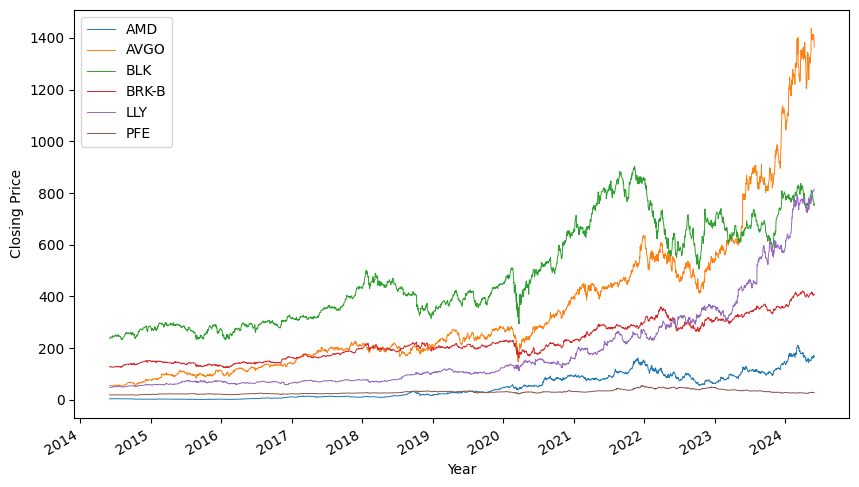

In [4]:
adj_close_data.plot(figsize=(10, 6), linewidth=0.7)
plt.legend()
plt.ylabel('Closing Price')
plt.xlabel('Year')
plt.show()

### Calcolo i rendimenti cumulati

In [5]:
cumulative_returns = (1 + (adj_close_data / adj_close_data.shift(1) - 1)).cumprod()
cumulative_returns

Ticker            AMD       AVGO       BLK     BRK-B        LLY       PFE
Date                                                                     
2014-06-02        NaN        NaN       NaN       NaN        NaN       NaN
2014-06-03   0.992443   0.997348  1.008431  0.992571   0.997647  0.995961
2014-06-04   1.017632   0.999581  1.015423  0.994917   0.995461  0.997644
2014-06-05   1.027708   1.003210  1.019073  1.002502   1.001513  1.001683
2014-06-06   1.022670   0.999861  1.032324  1.006021   1.002353  0.990239
...               ...        ...       ...       ...        ...       ...
2024-05-23  40.410577  25.573626  3.304237  3.173913  16.615926  1.491576
2024-05-24  41.904282  25.840687  3.293076  3.185877  16.594962  1.501453
2024-05-28  43.226700  25.925303  3.248896  3.158430  16.603799  1.471300
2024-05-29  41.596977  25.525536  3.186438  3.159916  16.679229  1.446345
2024-05-30  42.002519  25.037479  3.208675  3.195261  16.751780  1.466101

[2517 rows x 6 columns]

### Calcolo i rendimenti composti annui

In [6]:
time_delta = datetime.datetime.strptime(END_DATE, '%Y-%m-%d') - datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
time = time_delta/datetime.timedelta(days=1)

cagr = (adj_close_data.iloc[-1] / adj_close_data.iloc[0]) ** (365 / time) - 1
cagr

Ticker
AMD      0.452761
AVGO     0.379571
BLK      0.123546
BRK-B    0.123076
LLY      0.325274
PFE      0.038969
dtype: float64

### Calcolo dei rendimenti semplici

In [7]:
adjusted_close_returns = adj_close_data.pct_change()
monthly_mean_returns = adjusted_close_returns.groupby(pd.Grouper(freq='ME')).mean()
adjusted_close_returns.dropna(inplace=True)
adjusted_close_returns.head()

Ticker           AMD      AVGO       BLK     BRK-B       LLY       PFE
Date                                                                  
2014-06-03 -0.007557 -0.002652  0.008431 -0.007429 -0.002353 -0.004039
2014-06-04  0.025381  0.002240  0.006934  0.002364 -0.002191  0.001690
2014-06-05  0.009901  0.003631  0.003595  0.007624  0.006079  0.004048
2014-06-06 -0.004902 -0.003339  0.013003  0.003510  0.000839 -0.011425
2014-06-09  0.002463  0.002234  0.001943 -0.005130  0.001845 -0.002379

### Mostro un grafico con i rendimenti semplici calcolati per azione

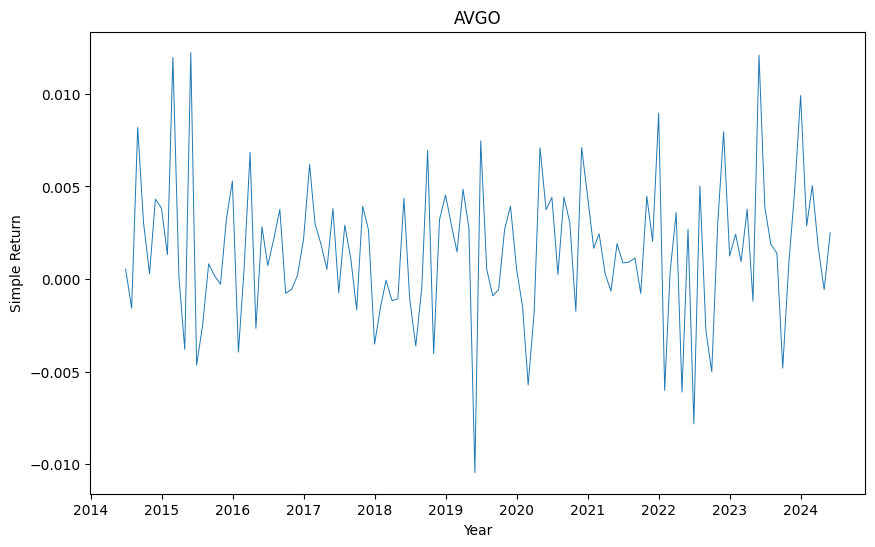

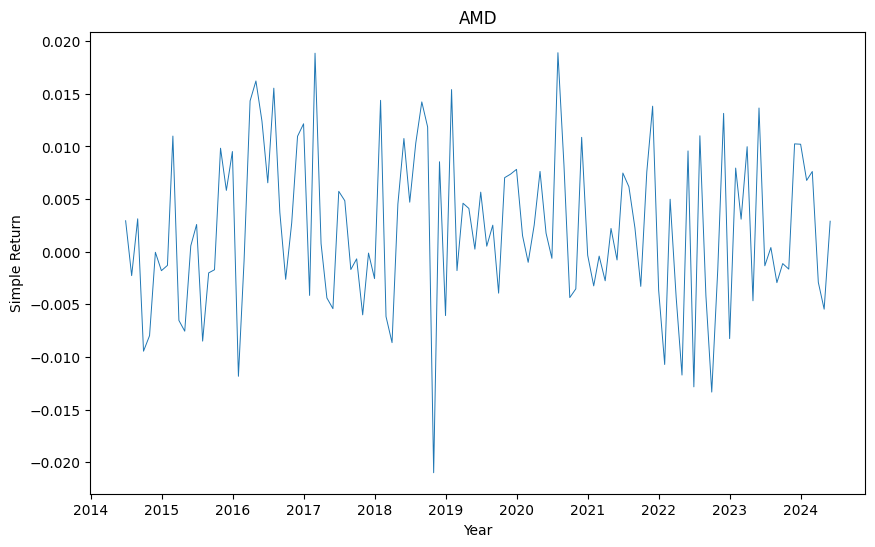

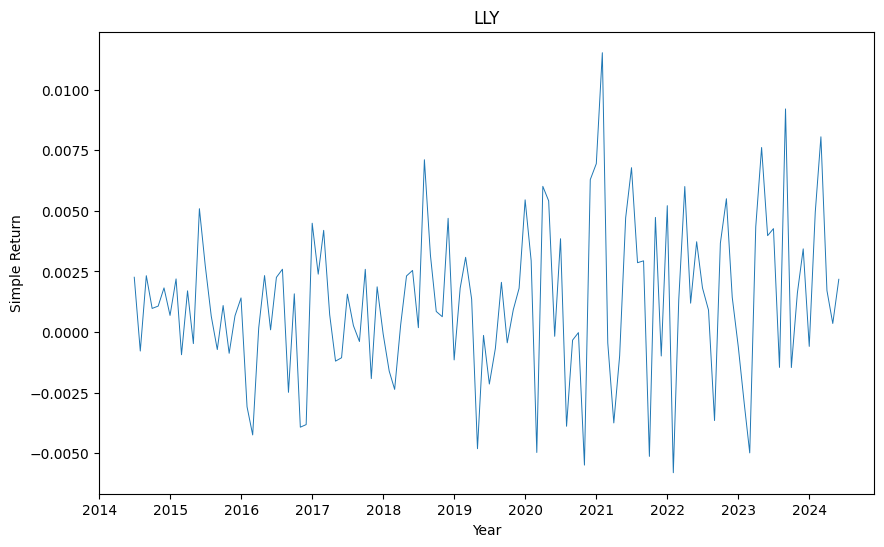

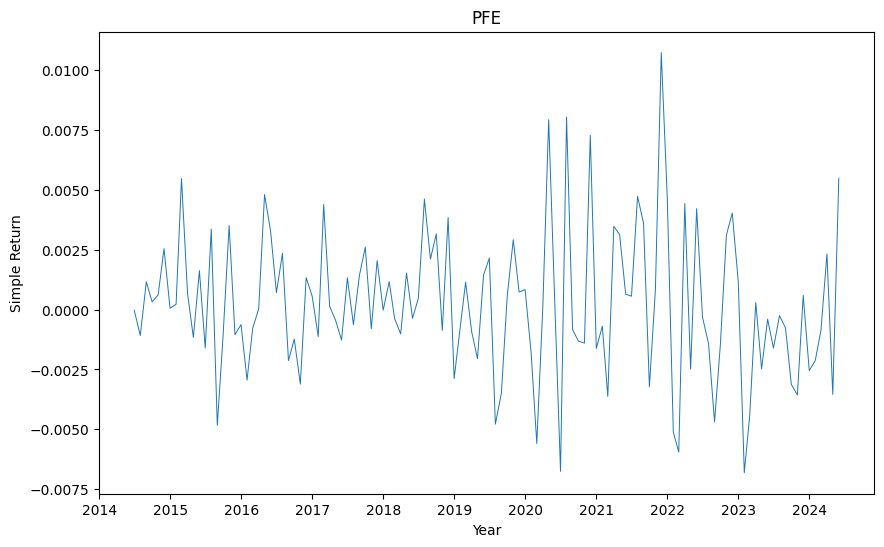

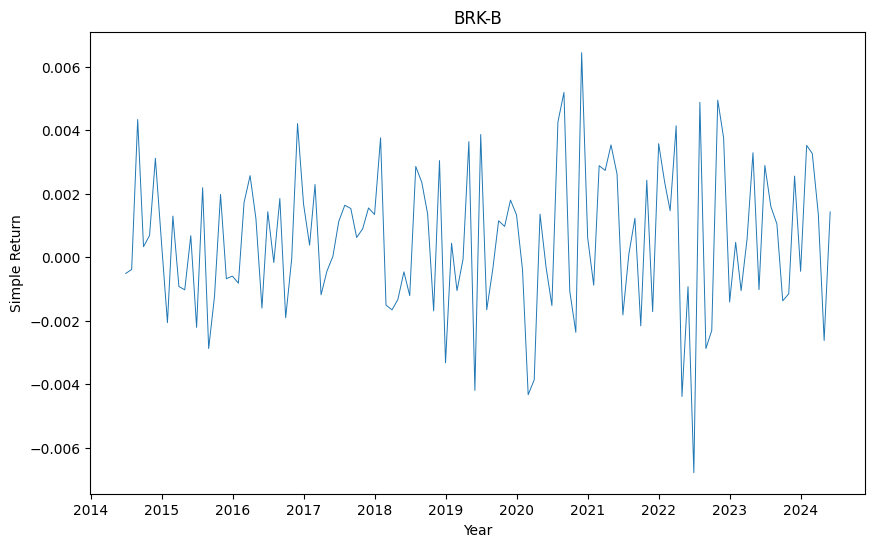

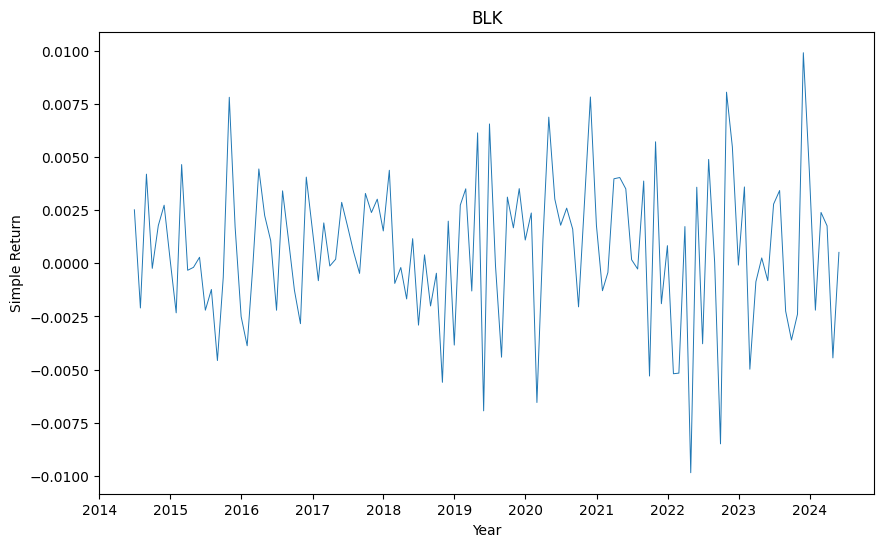

In [8]:
for ticker in selected_stocks:
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_mean_returns[ticker], linewidth=0.7)
    plt.ylabel('Simple Return')
    plt.xlabel('Year')
    plt.title(ticker)
    plt.show()

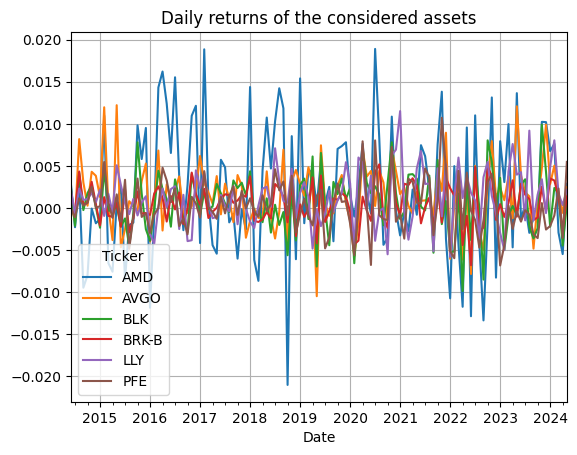

In [9]:
monthly_mean_returns.plot(title='Daily returns of the considered assets')
plt.grid();

### Calcolo i rendimenti logaritmici

In [10]:
logarithmic_returns = np.log(adj_close_data / adj_close_data.shift(1))
monthly_mean_logarithmic_returns = logarithmic_returns.groupby(pd.Grouper(freq='ME')).mean()
logarithmic_returns.dropna(inplace=True)
logarithmic_returns.head()

Ticker           AMD      AVGO       BLK     BRK-B       LLY       PFE
Date                                                                  
2014-06-03 -0.007585 -0.002656  0.008395 -0.007457 -0.002356 -0.004047
2014-06-04  0.025064  0.002237  0.006910  0.002361 -0.002193  0.001688
2014-06-05  0.009852  0.003624  0.003588  0.007595  0.006061  0.004040
2014-06-06 -0.004914 -0.003345  0.012919  0.003504  0.000839 -0.011491
2014-06-09  0.002460  0.002232  0.001941 -0.005143  0.001843 -0.002382

### Mostro le statistiche sui rendimenti logaritmici

In [11]:
logarithmic_returns.describe()

Ticker          AMD         AVGO          BLK        BRK-B          LLY  \
count   2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean       0.001486     0.001280     0.000463     0.000462     0.001120   
std        0.036220     0.022179     0.017147     0.012110     0.016900   
min       -0.277456    -0.222055    -0.146815    -0.100838    -0.111094   
25%       -0.016697    -0.009964    -0.007751    -0.005321    -0.006760   
50%        0.000586     0.001316     0.000778     0.000481     0.000961   
75%        0.019693     0.012688     0.008739     0.006540     0.008839   
max        0.420617     0.146985     0.126843     0.109840     0.145656   

Ticker          PFE  
count   2516.000000  
mean       0.000152  
std        0.014355  
min       -0.080502  
25%       -0.006726  
50%        0.000000  
75%        0.007011  
max        0.103055

### Mostro un grafico con i rendimenti logaritmici calcolati per azione

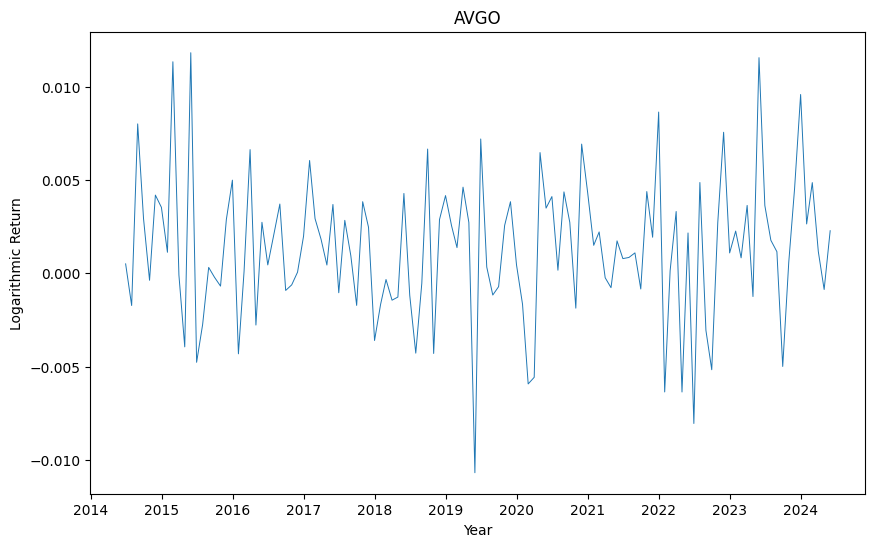

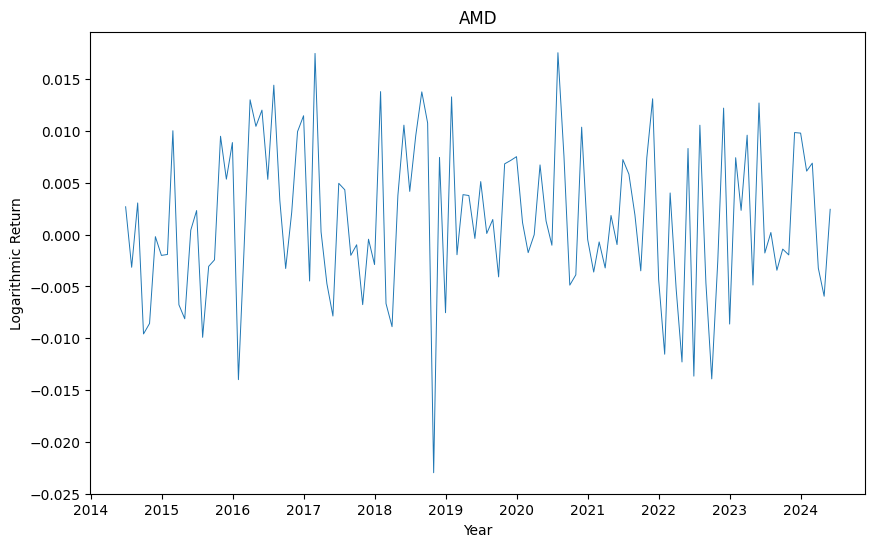

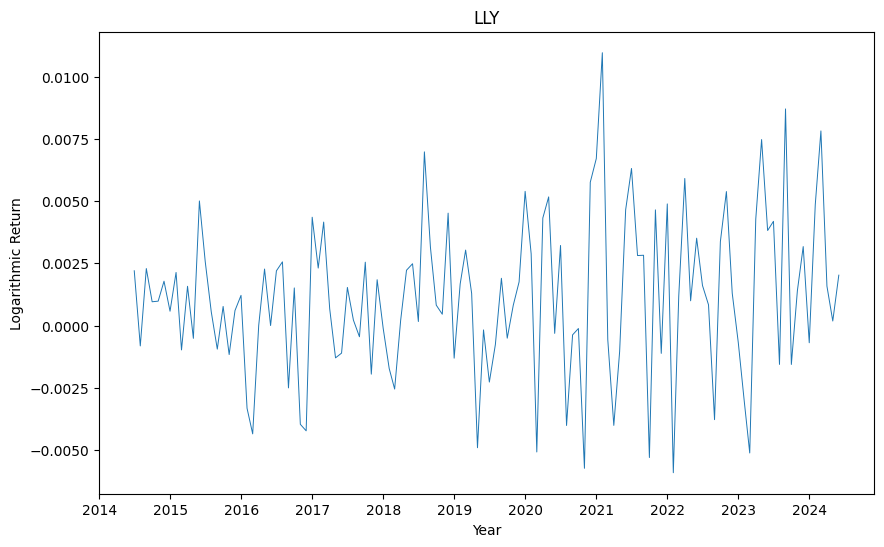

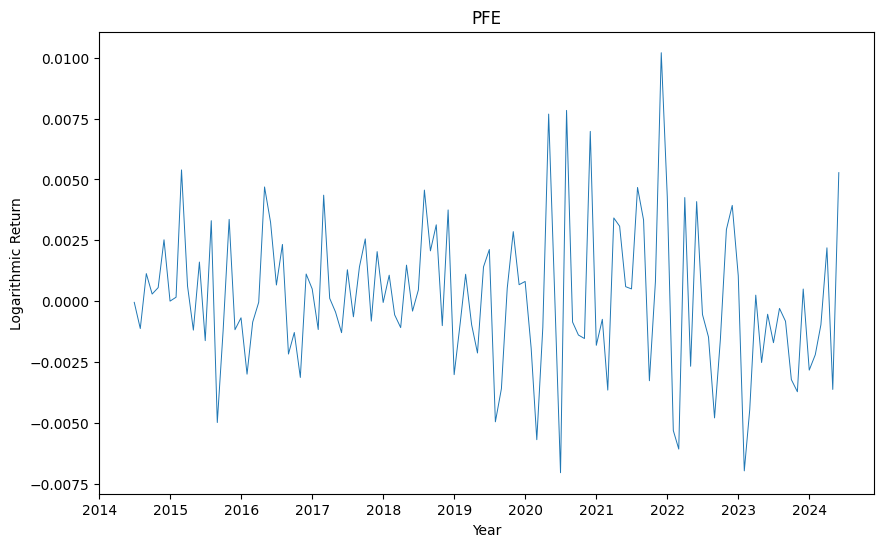

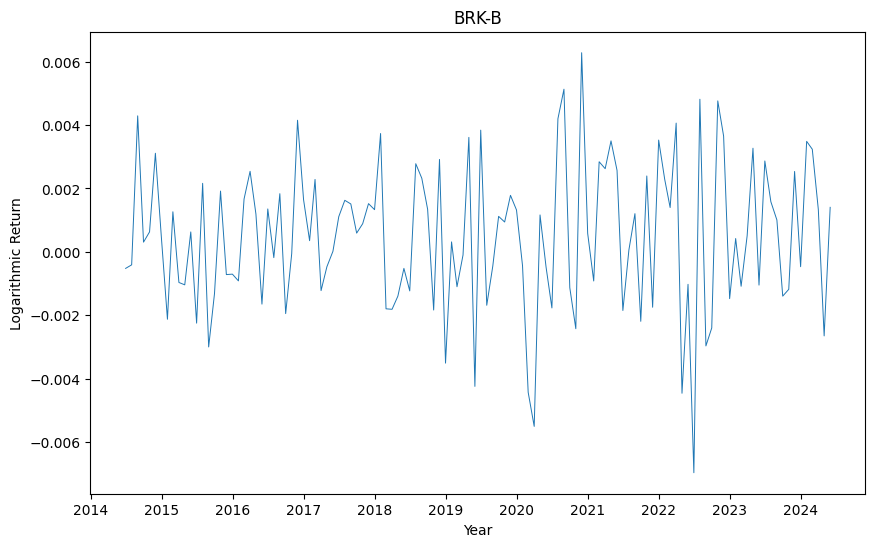

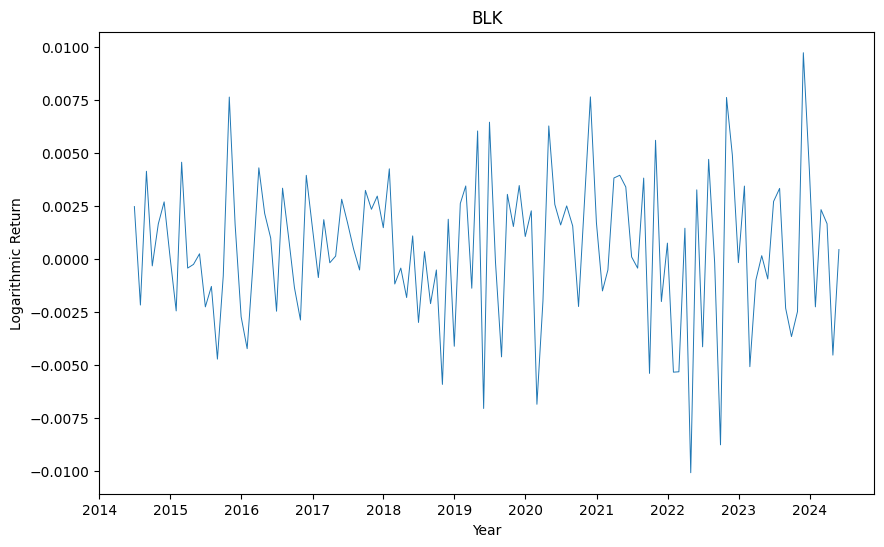

In [12]:
for ticker in selected_stocks:
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_mean_logarithmic_returns[ticker], linewidth=0.7)
    plt.ylabel('Logarithmic Return')
    plt.xlabel('Year')
    plt.title(ticker)
    plt.show()

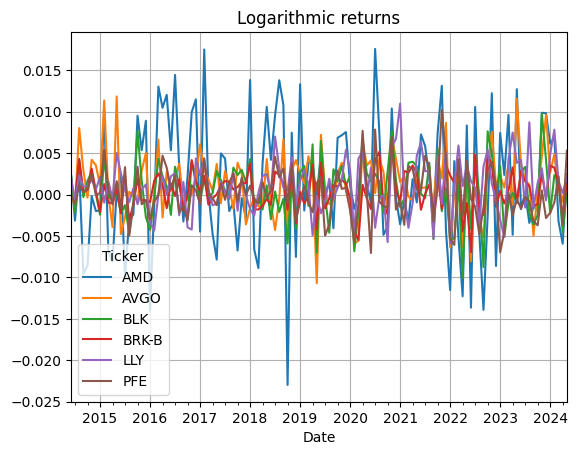

In [13]:
monthly_mean_logarithmic_returns.plot(title="Logarithmic returns")
plt.grid()

### Mostro i grafici diagnostici dei rendimenti logaritmici per titolo

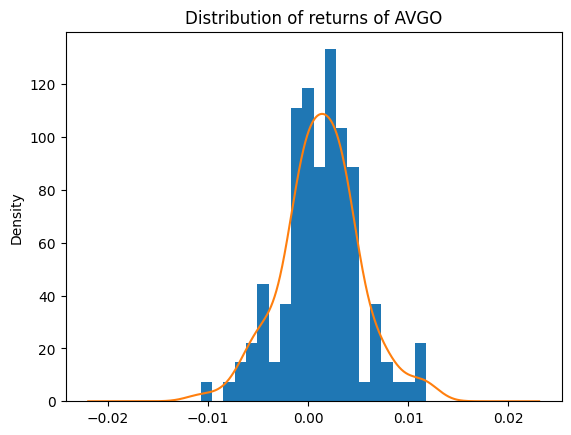

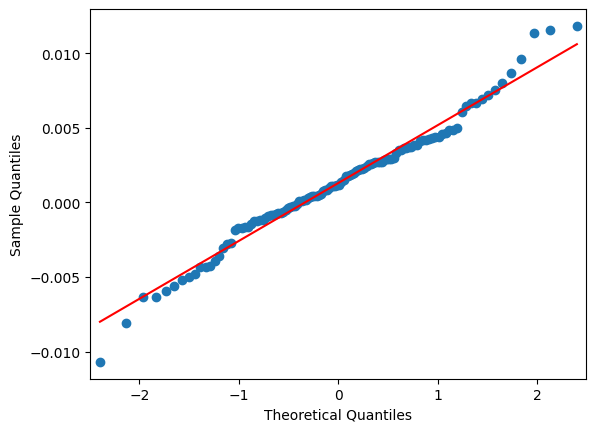

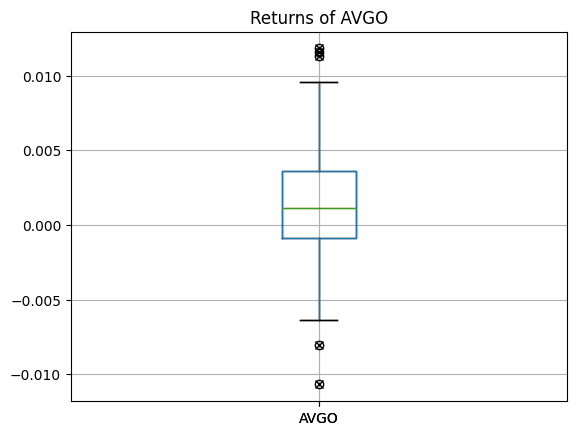

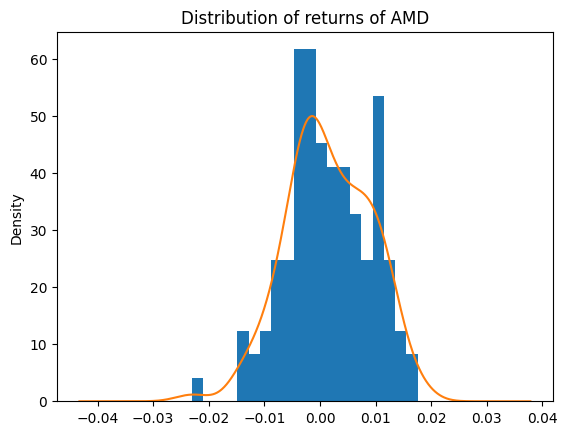

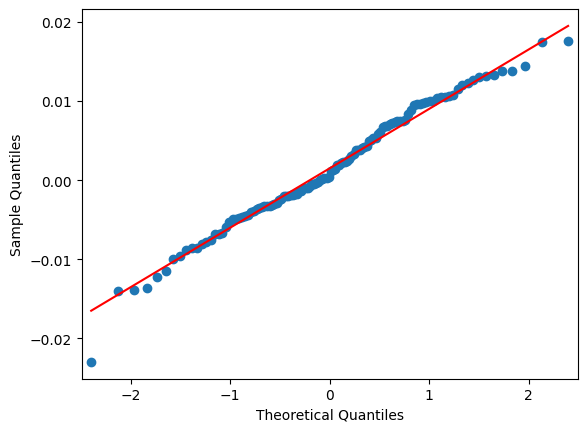

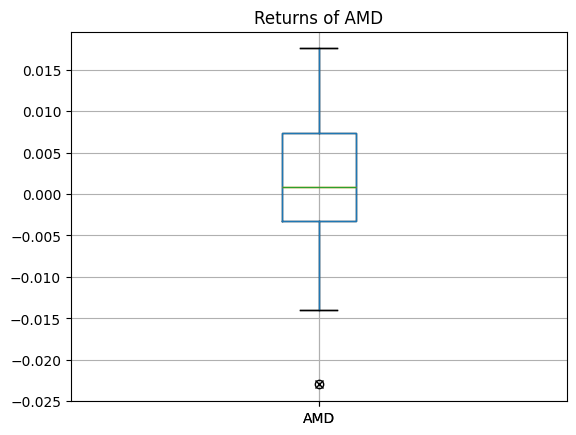

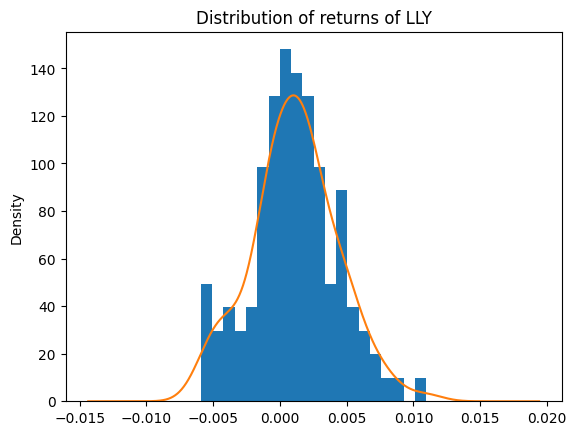

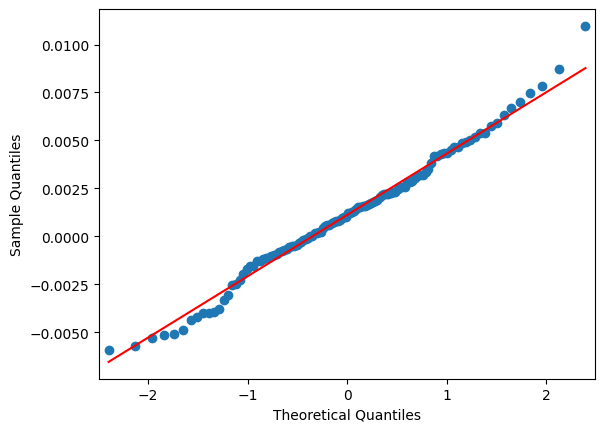

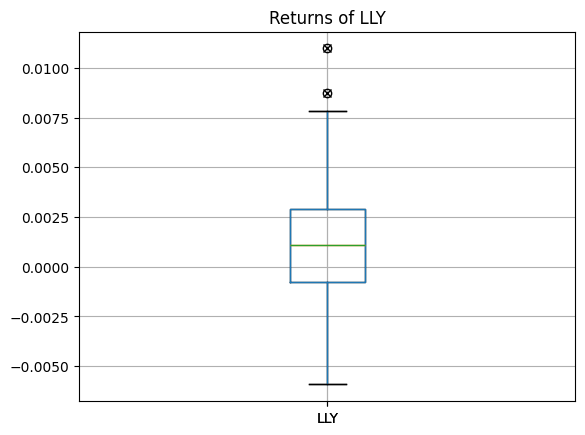

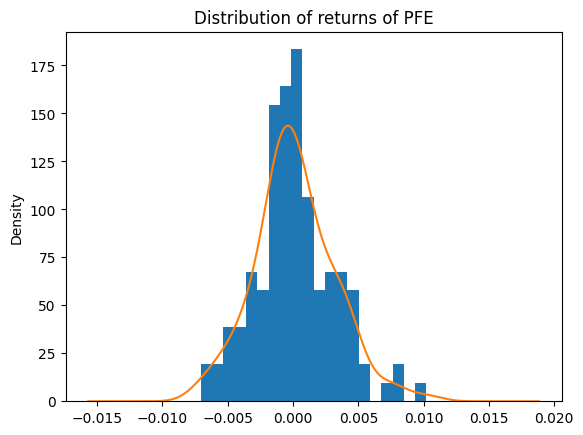

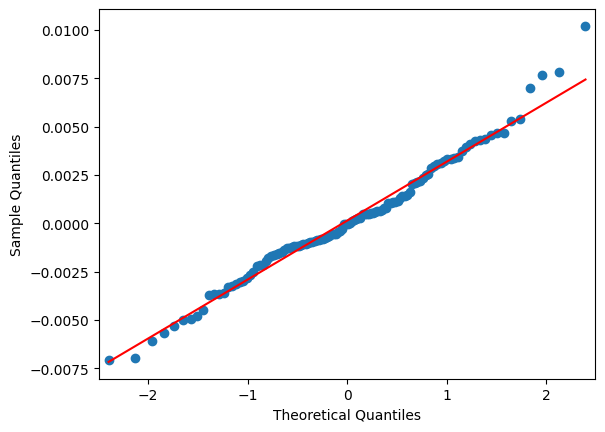

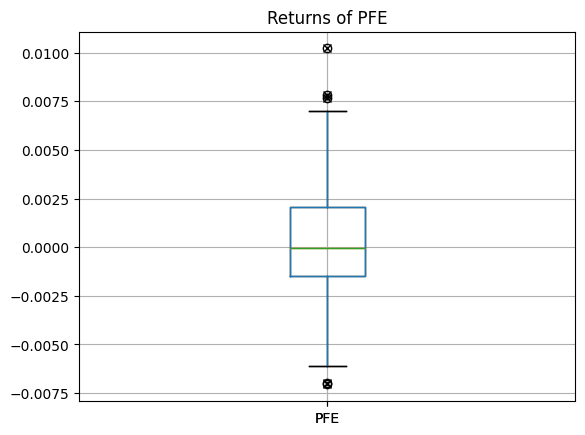

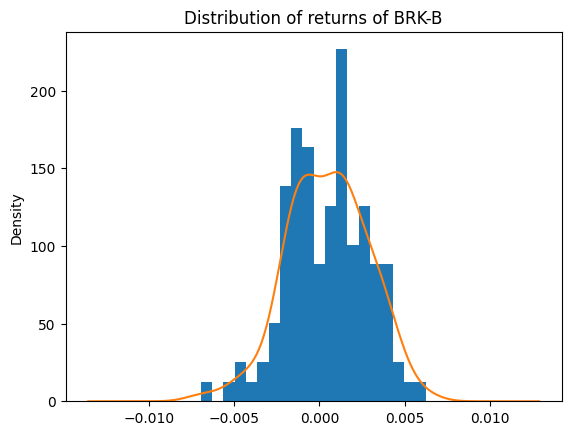

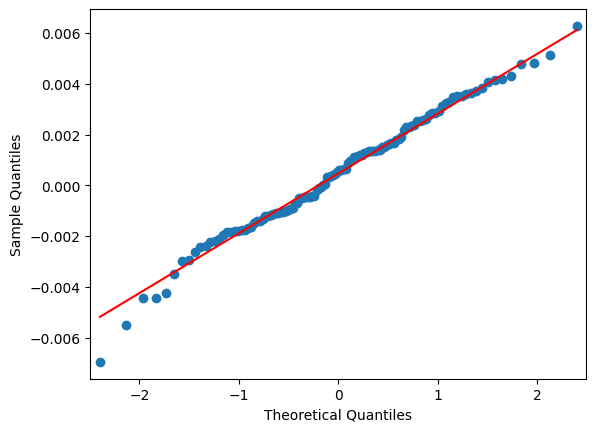

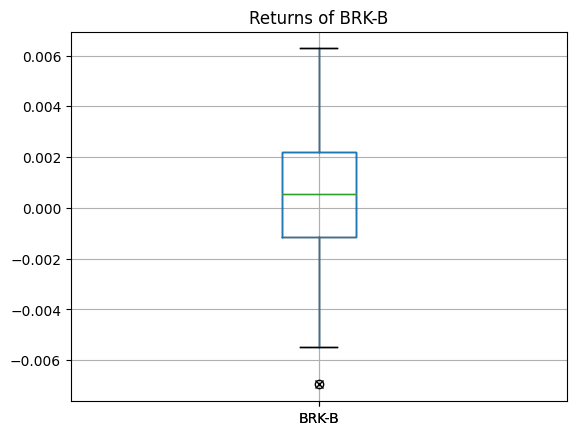

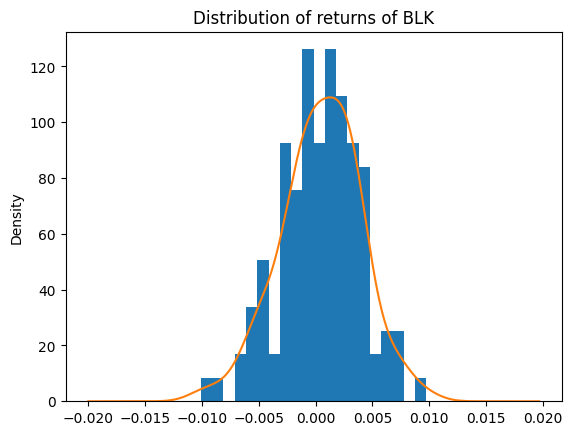

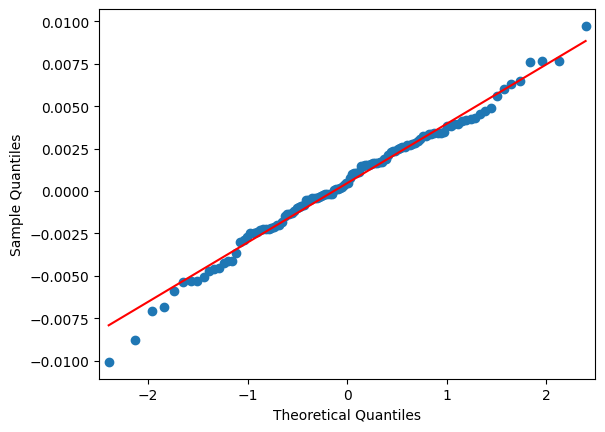

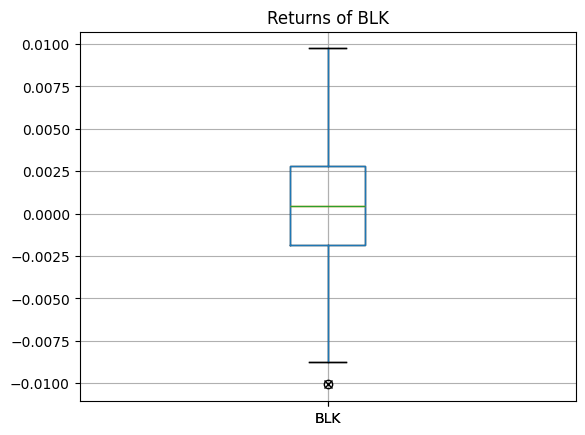

In [14]:
for ticker in selected_stocks:
    plt.figure()
    plt.hist(monthly_mean_logarithmic_returns[ticker], density = True, bins=20)
    plt.title(f"Distribution of returns of {ticker}")
    monthly_mean_logarithmic_returns[ticker].plot.density()

    sm.qqplot(monthly_mean_logarithmic_returns[ticker], line = 's')

    plt.figure()
    plt.boxplot(monthly_mean_logarithmic_returns[ticker], sym = 'x')
    plt.title(f"Returns of {ticker}")
    monthly_mean_logarithmic_returns[ticker].to_frame().boxplot()

plt.show()

### Calcolo le statistiche descrittive univariate
- Media
- Varianza
- Deviazione Standard
- Asimmetria
- Curtosi

In [65]:
results = []
for ticker in selected_stocks:
    mean_return = round(logarithmic_returns[ticker].mean(), 4)
    variance_return = round(logarithmic_returns[ticker].var(), 4)
    std_deviation_return = round(logarithmic_returns[ticker].std(), 4)
    skewness_return = round(logarithmic_returns[ticker].skew(), 4)
    kurtosis_return = round(logarithmic_returns[ticker].kurtosis(), 4)
    
    results.append({
        'Ticker': ticker,
        'Mean Return': mean_return,
        'Variance': variance_return,
        'Standard Deviation': std_deviation_return,
        'Skewness': skewness_return,
        'Kurtosis': kurtosis_return
    })

stats_df = pd.DataFrame(results)
stats_df.set_index('Ticker', inplace=True)
transposed_df = stats_df.transpose()
transposed_df
    

Ticker                AVGO      AMD      LLY     PFE    BRK-B     BLK
Mean Return         0.0013   0.0015   0.0011  0.0002   0.0005  0.0005
Variance            0.0005   0.0013   0.0003  0.0002   0.0001  0.0003
Standard Deviation  0.0222   0.0362   0.0169  0.0144   0.0121  0.0171
Skewness           -0.4277   0.4757   0.7395  0.1503  -0.2482 -0.1606
Kurtosis            9.3448  10.6656  10.7300  5.1215  11.2449  8.7427

### Calcolo la correlazione tra i rendimenti logaritmici dei titoli tecnologici

In [16]:
it_sector_correlation = logarithmic_returns['AMD'].corr(logarithmic_returns['AVGO'])
print(f"IT Sector Correlation: {it_sector_correlation}")

IT Sector Correlation: 0.44695953738301597


### Calcolo la correlazione tra i rendimenti logaritmici dei titoli sanitari

In [17]:
healthcare_sector_correlation = logarithmic_returns['PFE'].corr(logarithmic_returns['LLY'])
print(f"Healthcare Sector Correlation: {healthcare_sector_correlation}")

Healthcare Sector Correlation: 0.43406618756397336


### Calcolo la correlazione tra i rendimenti logaritmici dei titoli finanziari

In [18]:
finance_sector_correlation = logarithmic_returns['BLK'].corr(logarithmic_returns['BRK-B'])
print(f"Finance Sector Correlation: {finance_sector_correlation}")

Finance Sector Correlation: 0.7064242872618788


### Calcolo matrice di covarianza

In [19]:
covariance_matrix = logarithmic_returns.cov()
print(covariance_matrix)

Ticker       AMD      AVGO       BLK     BRK-B       LLY       PFE
Ticker                                                            
AMD     0.001312  0.000359  0.000233  0.000137  0.000104  0.000093
AVGO    0.000359  0.000492  0.000207  0.000130  0.000094  0.000081
BLK     0.000233  0.000207  0.000294  0.000147  0.000094  0.000099
BRK-B   0.000137  0.000130  0.000147  0.000147  0.000075  0.000081
LLY     0.000104  0.000094  0.000094  0.000075  0.000286  0.000105
PFE     0.000093  0.000081  0.000099  0.000081  0.000105  0.000206


### Calcolo matrice di correlazione

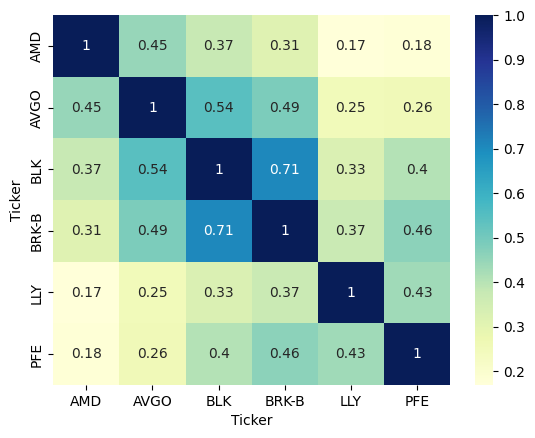

In [20]:
correlation_matrix = logarithmic_returns.corr()
dataplot = sb.heatmap(correlation_matrix, cmap="YlGnBu", annot=True)
plt.show()

### Calcolo correlazione nel tempo per ogni settore

In [21]:
it_sector_correlation_over_time = logarithmic_returns['AMD'].rolling(window=90).corr(logarithmic_returns['AVGO'])
healthcare_sector_correlation_over_time = logarithmic_returns['PFE'].rolling(window=90).corr(logarithmic_returns['LLY'])
finance_sector_correlation_over_time = logarithmic_returns['BLK'].rolling(window=90).corr(logarithmic_returns['BRK-B'])

### Mostro grafico correlazione nel tempo per il settore tecnologico

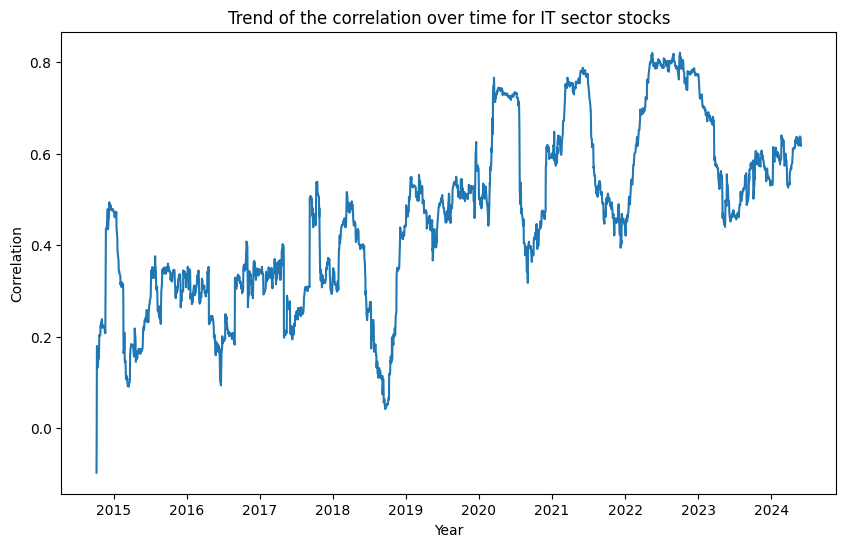

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(it_sector_correlation_over_time.index, it_sector_correlation_over_time)
ax.set_xlabel('Year')
ax.set_ylabel('Correlation')
ax.set_title('Trend of the correlation over time for IT sector stocks')
plt.show()

### Mostro grafico correlazione nel tempo per il settore sanitario

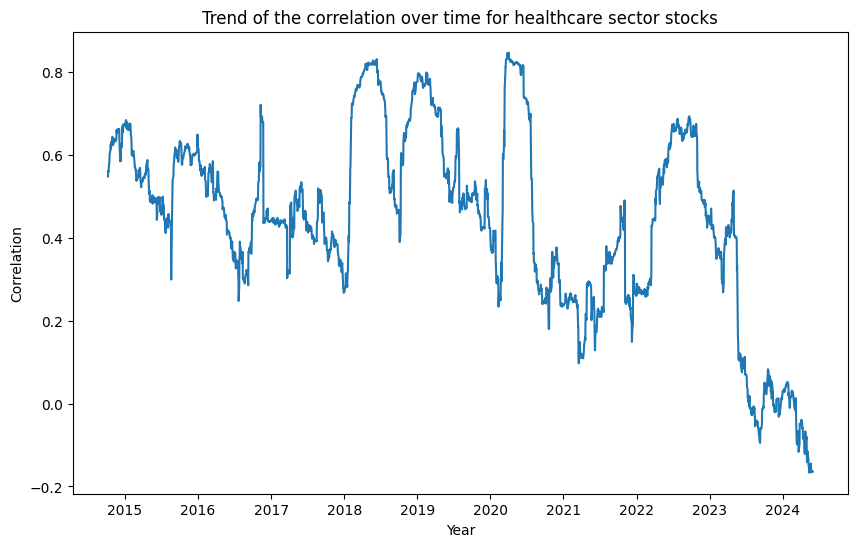

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(healthcare_sector_correlation_over_time.index, healthcare_sector_correlation_over_time)
ax.set_xlabel('Year')
ax.set_ylabel('Correlation')
ax.set_title('Trend of the correlation over time for healthcare sector stocks')
plt.show()

### Mostro grafico correlazione nel tempo per il settore bancario

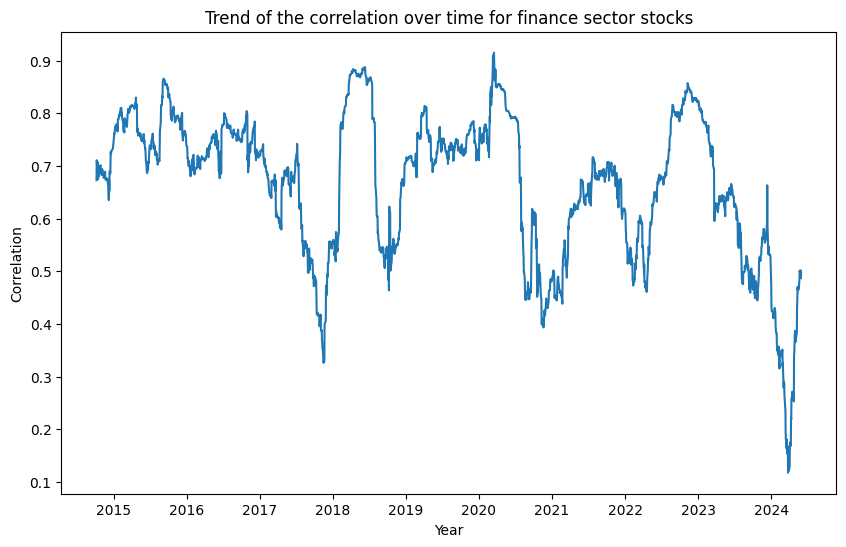

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(finance_sector_correlation_over_time.index, finance_sector_correlation_over_time)
ax.set_xlabel('Year')
ax.set_ylabel('Correlation')
ax.set_title('Trend of the correlation over time for finance sector stocks')
plt.show()

### Calcolo media delle correlazioni

In [25]:
mean_correlation = correlation_matrix.mean()

### Mostro il grafico di dispersione delle correlazione medie tra i titoli tecnologici

Text(0, 0.5, 'AMD')

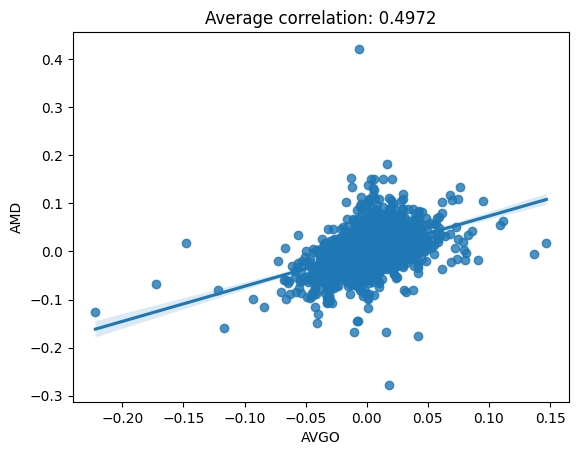

In [26]:
plt.figure()
sns.regplot(x=logarithmic_returns['AVGO'], y=logarithmic_returns['AMD'], data=logarithmic_returns)
plt.title("Average correlation: " + str(round(mean_correlation['AVGO'], 4)))
plt.xlabel('AVGO')
plt.ylabel('AMD')

### Mostro il grafico di dispersione delle correlazione medie tra i titoli sanitari

Text(0, 0.5, 'PFE')

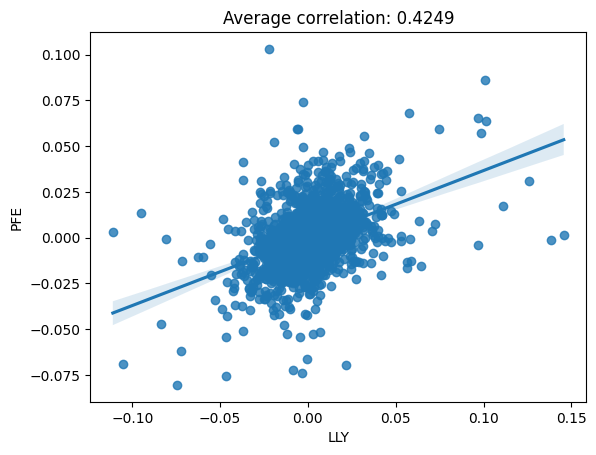

In [27]:
plt.figure()
sns.regplot(x=logarithmic_returns['LLY'], y=logarithmic_returns['PFE'], data=logarithmic_returns)
plt.title("Average correlation: " + str(round(mean_correlation['LLY'], 4)))
plt.xlabel('LLY')
plt.ylabel('PFE')

### Mostro il grafico di dispersione delle correlazione medie tra i titoli bancari

Text(0, 0.5, 'BLK')

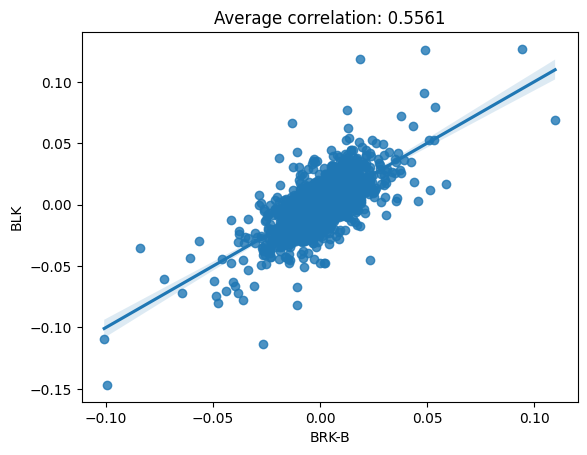

In [28]:
plt.figure()
sns.regplot(x=logarithmic_returns['BRK-B'], y=logarithmic_returns['BLK'], data=logarithmic_returns)
plt.title("Average correlation: " + str(round(mean_correlation['BRK-B'], 4)))
plt.xlabel('BRK-B')
plt.ylabel('BLK')

### Creo colonna con prezzo previsto a 5 giorni

In [29]:
FORECAST_DAYS = 5
for ticker in selected_stocks:
    column_position = adj_close_data.columns.get_loc(ticker) + 1
    adj_close_data.insert(
        column_position,
        f"{ticker}_5_Days_Price_Forecast",
        adj_close_data[ticker].shift(-FORECAST_DAYS)
    )

### Divido il dataset in base ai titoli

In [30]:
adj_close_forecasts = [
    adj_close_data[[ticker, f"{ticker}_5_Days_Price_Forecast"]]
    for ticker in selected_stocks
]

### Esecuzione modello SVM

SVM model confidence score for AVGO: 0.930938856499875
Mean Absolute Error for AVGO: 17.098031327448936
Mean Squared Error for AVGO: 468.48412871934084
R2 Score for AVGO: 0.902008957982275


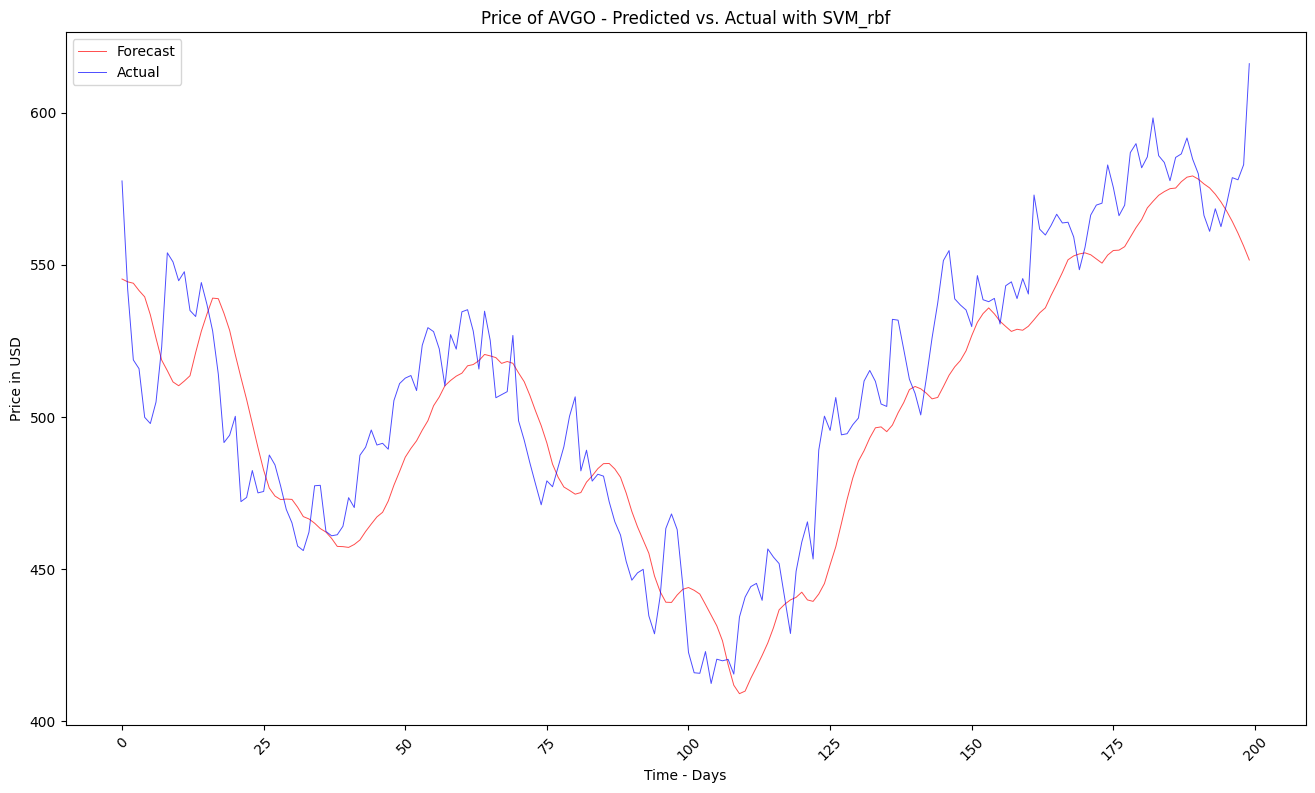

SVM model confidence score for AMD: 0.9295317141583804
Mean Absolute Error for AMD: 5.252784451862971
Mean Squared Error for AMD: 47.571228788361566
R2 Score for AMD: 0.9002271303214141


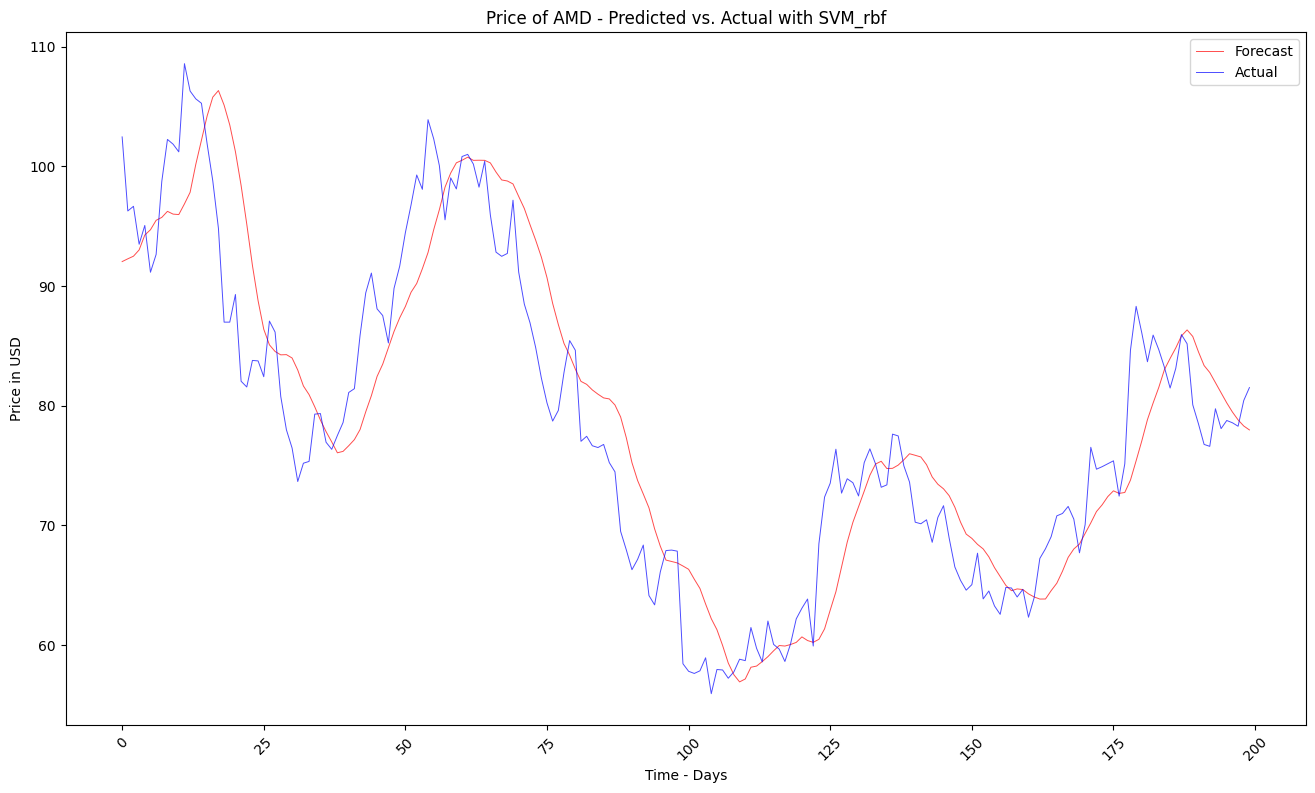

SVM model confidence score for LLY: 0.9203884116186143
Mean Absolute Error for LLY: 8.309602241364045
Mean Squared Error for LLY: 115.89843251791758
R2 Score for LLY: 0.9720322006292014


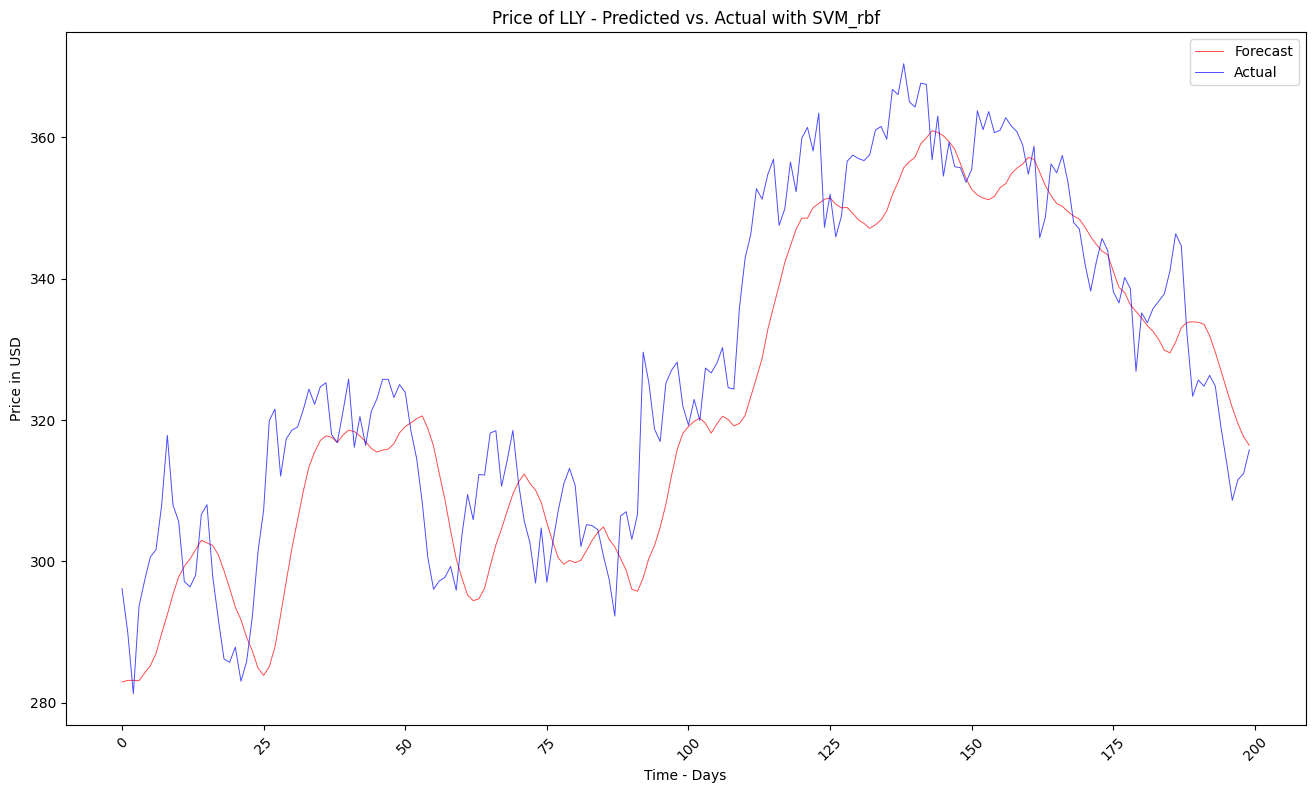

SVM model confidence score for PFE: 0.9453439652681435
Mean Absolute Error for PFE: 1.234388776903777
Mean Squared Error for PFE: 2.751768244502588
R2 Score for PFE: 0.9334186843056151


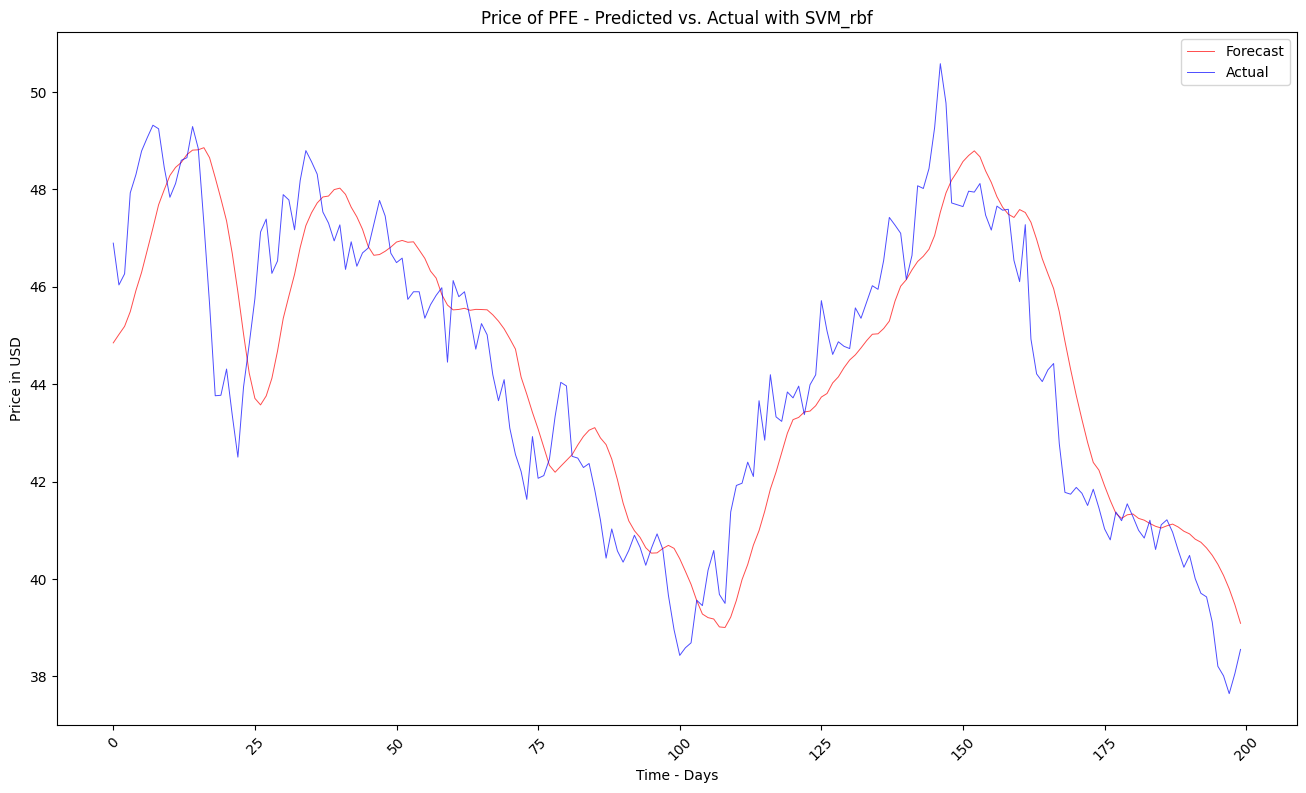

SVM model confidence score for BRK-B: 0.9418194634492808
Mean Absolute Error for BRK-B: 6.057625538634839
Mean Squared Error for BRK-B: 63.76416645169634
R2 Score for BRK-B: 0.9372949005767744


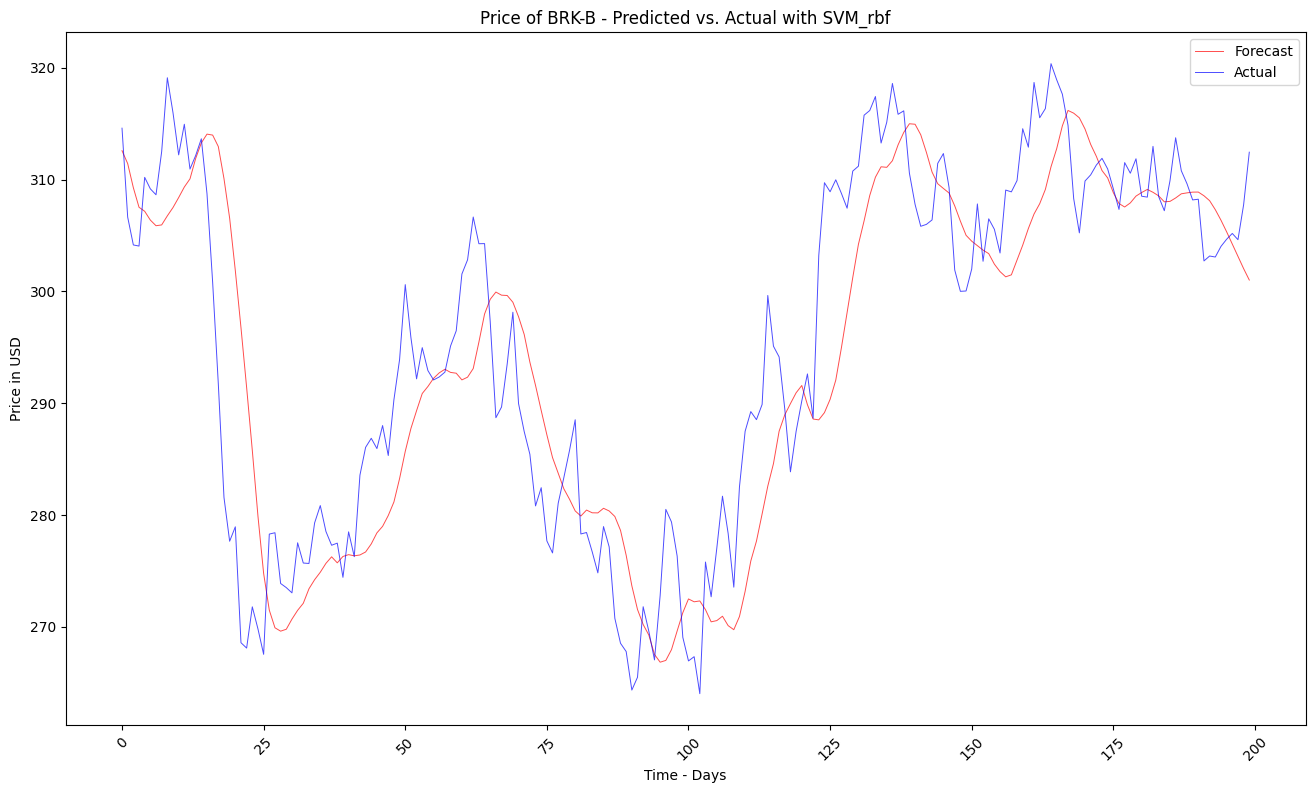

SVM model confidence score for BLK: 0.8632983112061992
Mean Absolute Error for BLK: 24.349094264309915
Mean Squared Error for BLK: 923.5901432447761
R2 Score for BLK: 0.8993167283953558


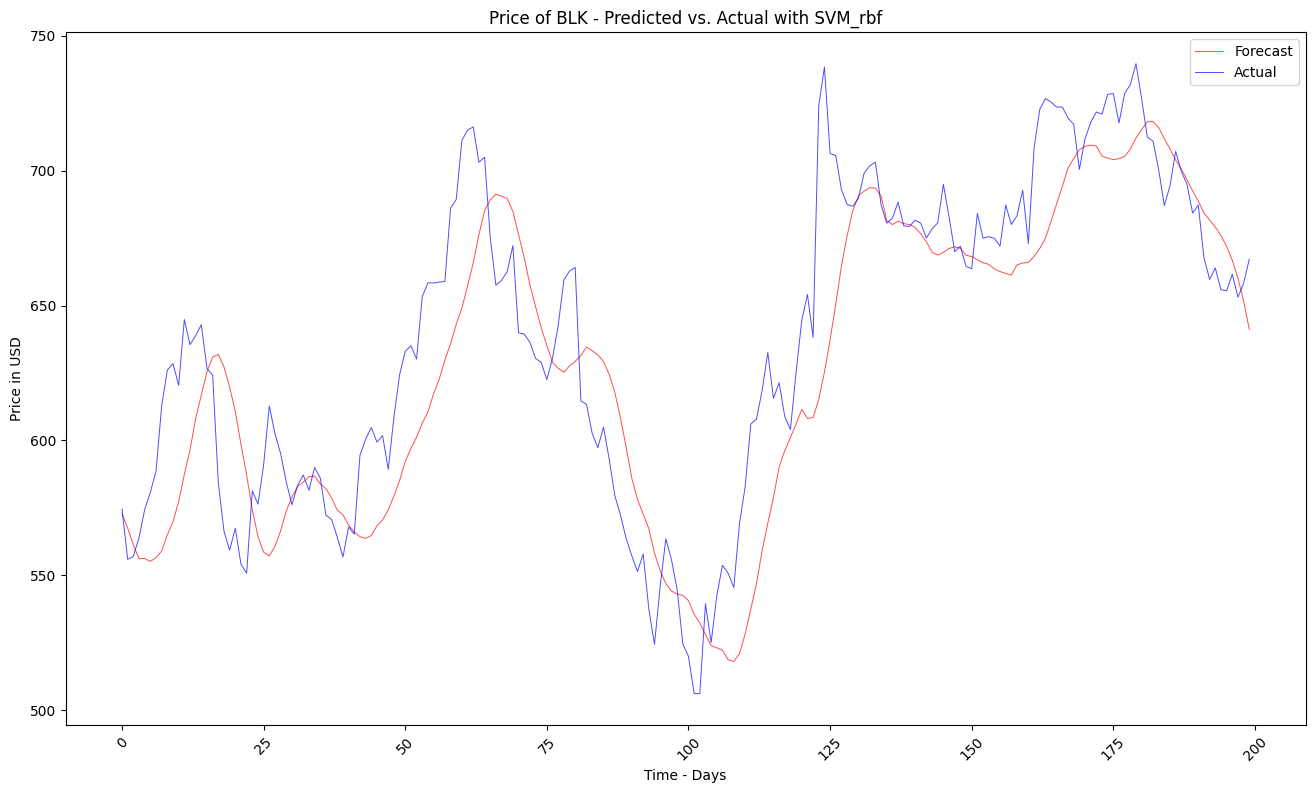

In [31]:
for df in adj_close_forecasts:

    feature_array = np.array(df.iloc[:, 0])
    feature_array = feature_array[:df.shape[0] - FORECAST_DAYS]
    feature_array = np.reshape(feature_array, (-1, 1))
    
    target_array = np.array(df.iloc[:, 1])
    target_array = target_array[:-FORECAST_DAYS]    

    #Divido i dati in set di training, validazione e test
    X_training = feature_array[:1600]
    y_training = target_array[:1600]
    X_validation = feature_array[1600:2200]
    y_validation = target_array[1600:2200]
    X_test = feature_array[2200:]
    y_test = target_array[2200:]

    #Standardizzazione dei dati
    scaler = StandardScaler()
    scaler.fit(X_training)
    x_training = scaler.transform(X_training)
    X_validation = scaler.transform(X_validation)
    X_test = scaler.transform(X_test)

    #Training del modello SVM
    svm_model = SVR(kernel='rbf', C = 1e3, gamma = 0.0001)
    svm_model.fit(x_training, y_training)

    #Valutazione del modello
    svm_model_confidence = svm_model.score(X_test, y_test)
    print(f'SVM model confidence score for {df.columns[0]}: {svm_model_confidence}')

    #Affinamento delle predizioni
    svm_predictions = svm_model.predict(X_test)
    svm_prediction_smooth = savgol_filter(svm_predictions, 15, 3)

    svm_val_predictions = svm_model.predict(X_validation)
    svm_val_predictions_smooth = savgol_filter(svm_val_predictions, 15, 3)

    #calcolo metriche di valutazione
    mae = mean_absolute_error(y_validation, svm_val_predictions)
    mse = mean_squared_error(y_validation, svm_val_predictions)
    r2 = r2_score(y_validation, svm_val_predictions)

    print(f'Mean Absolute Error for {df.columns[0]}: {mae}')
    print(f'Mean Squared Error for {df.columns[0]}: {mse}')
    print(f'R2 Score for {df.columns[0]}: {r2}')

    #Grafico dei risultati
    plt.figure(figsize=(16,9))
    plt.plot(svm_val_predictions_smooth[400:], label = 'Forecast', linewidth = '0.7', color ='r', alpha = .7)
    plt.plot(y_validation[400:], label = 'Actual', linewidth = '0.7', color ='b', alpha = .7)
    plt.title('Price of ' f"{df.columns[0]}" ' - Predicted vs. Actual with SVM_rbf')
    plt.ylabel('Price in USD')
    plt.xlabel('Time - Days')
    plt.legend()
    plt.xticks(rotation = 45)
    plt.show()

### Utilizzo stile ggplot

In [32]:
style.use('ggplot')

### Scarico i dati dei ticker in DataFrame separati

In [33]:
stock_dataframes = {}

for ticker in selected_stocks:
    stock_data = yf.download(ticker, start=START_DATE, end=END_DATE)
    stock_data = stock_data.drop(columns=['High', 'Low', 'Open', 'Close'])
    stock_dataframes[f"df_{ticker}"] = stock_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Creo le due serie mobili

In [34]:
for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_dataframes[dataframe_key]['SMA20'] = stock_dataframes[dataframe_key]['Adj Close'].rolling(20).mean()
    stock_dataframes[dataframe_key]['SMA120'] = stock_dataframes[dataframe_key]['Adj Close'].rolling(120).mean()

### Mostro un grafico per ogni azione

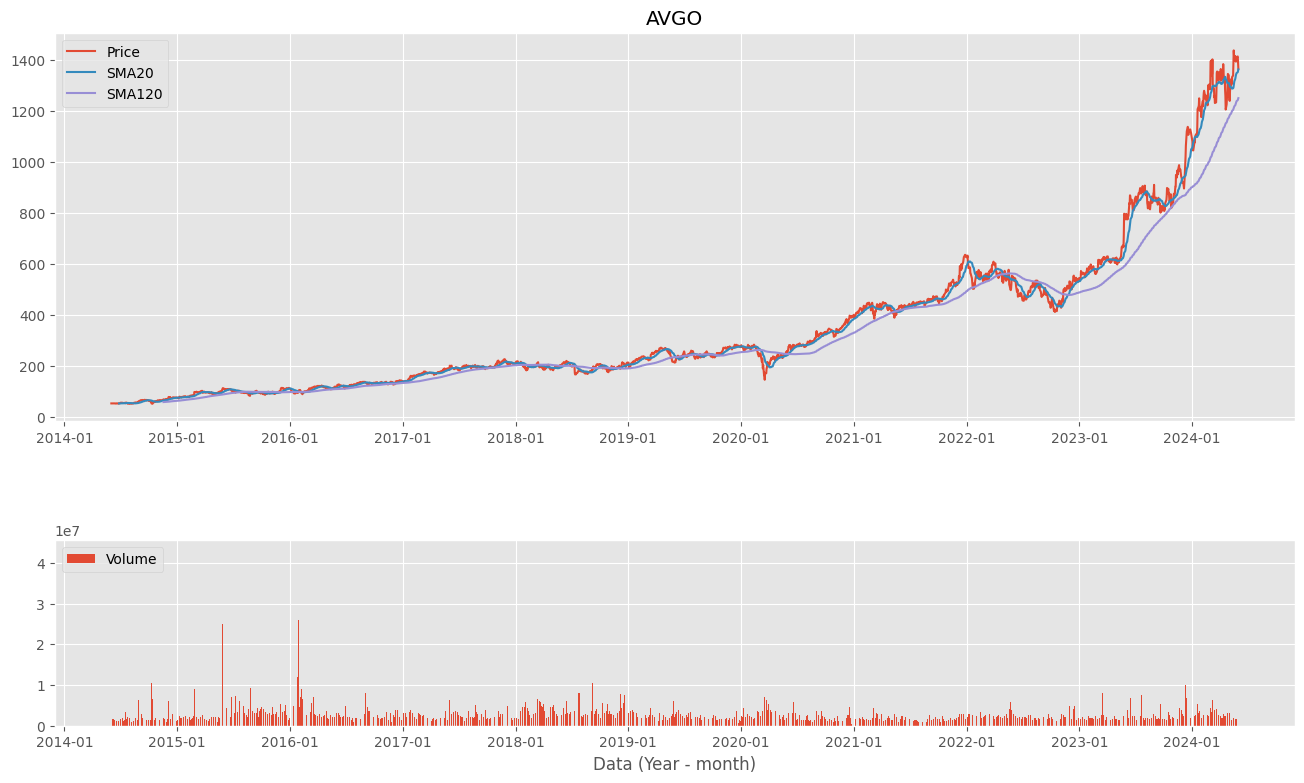

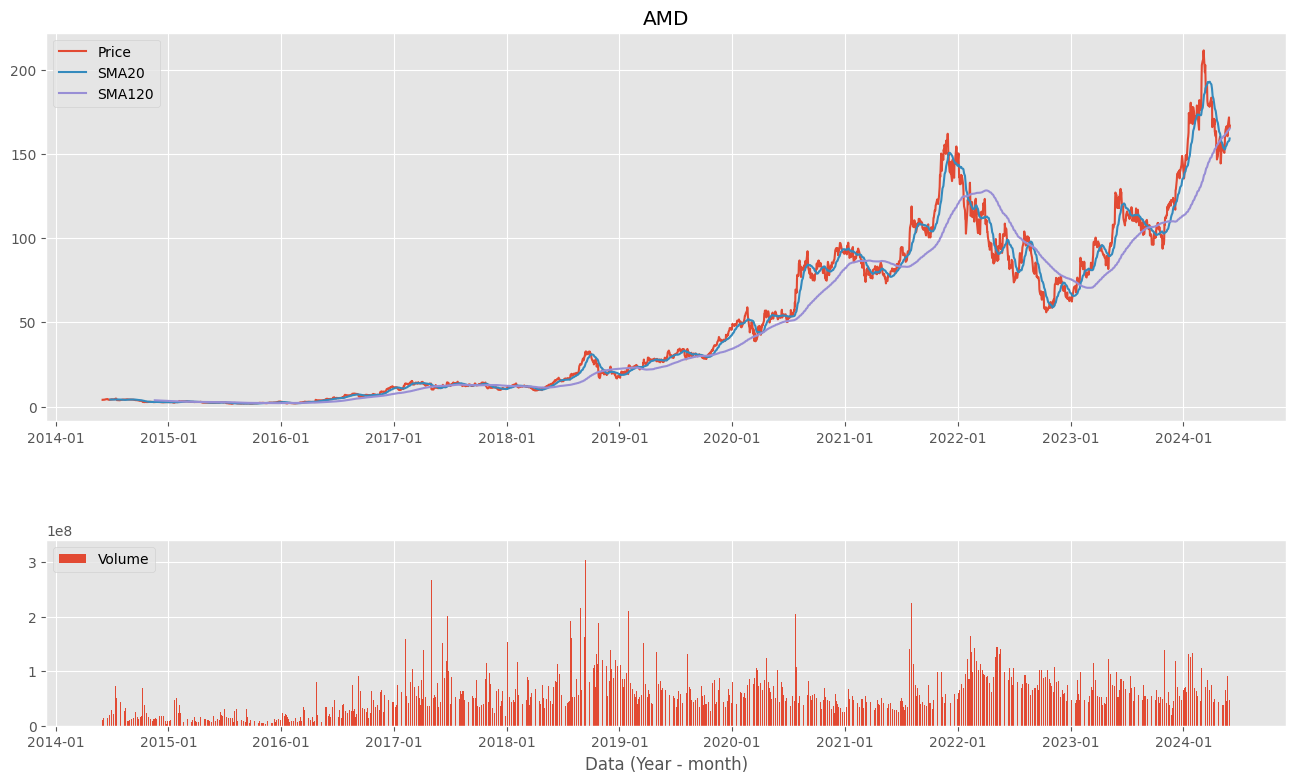

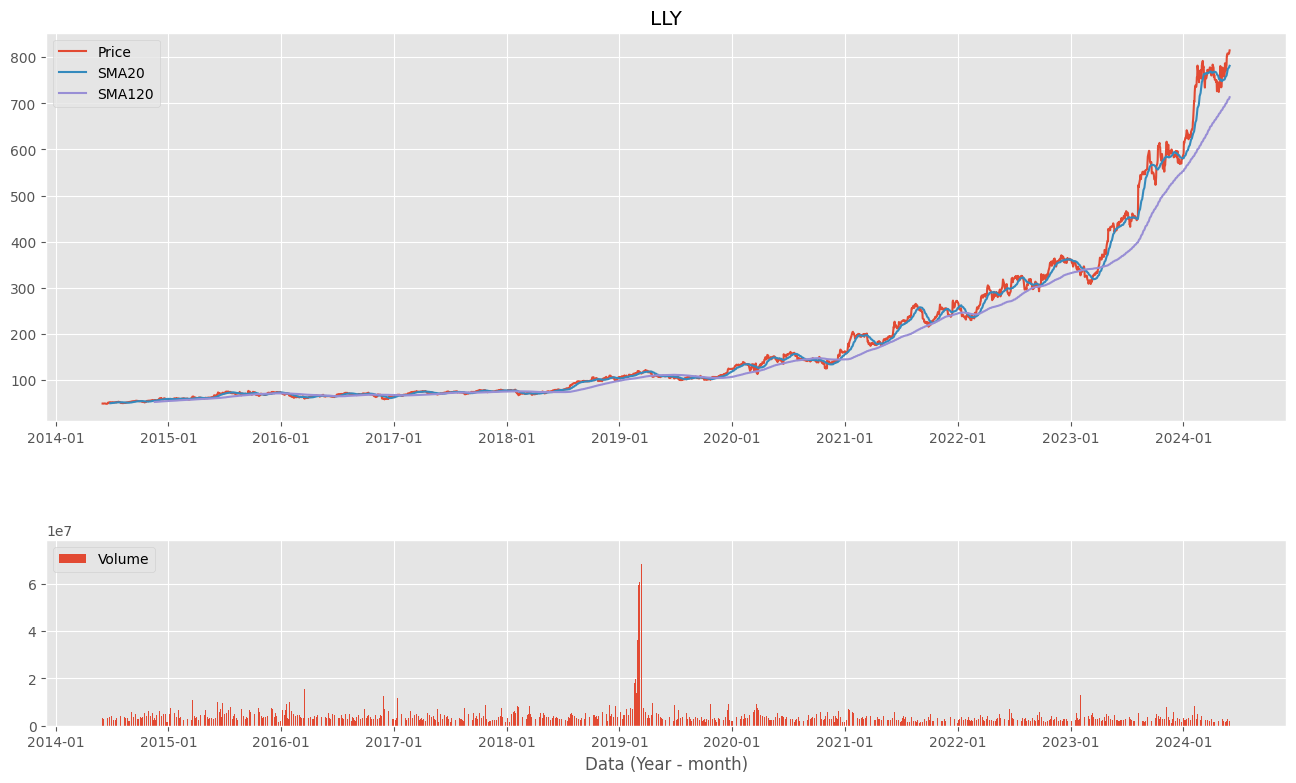

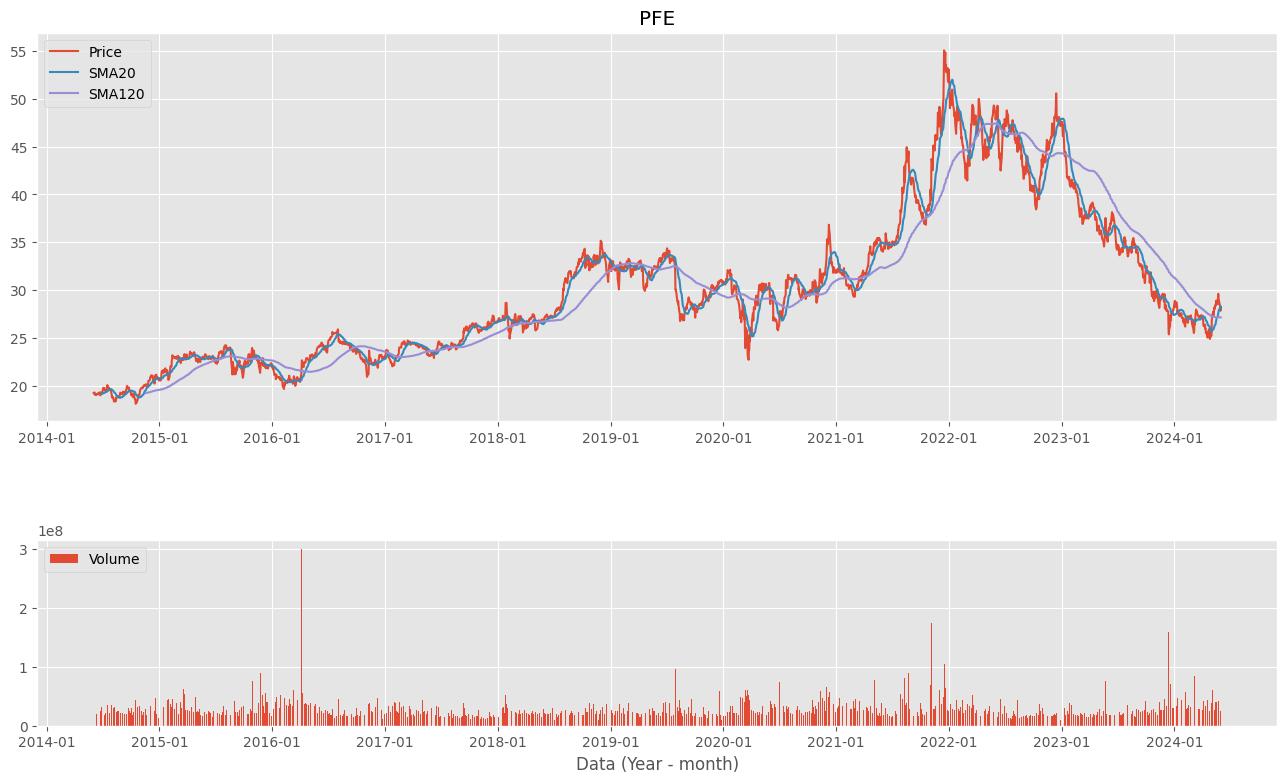

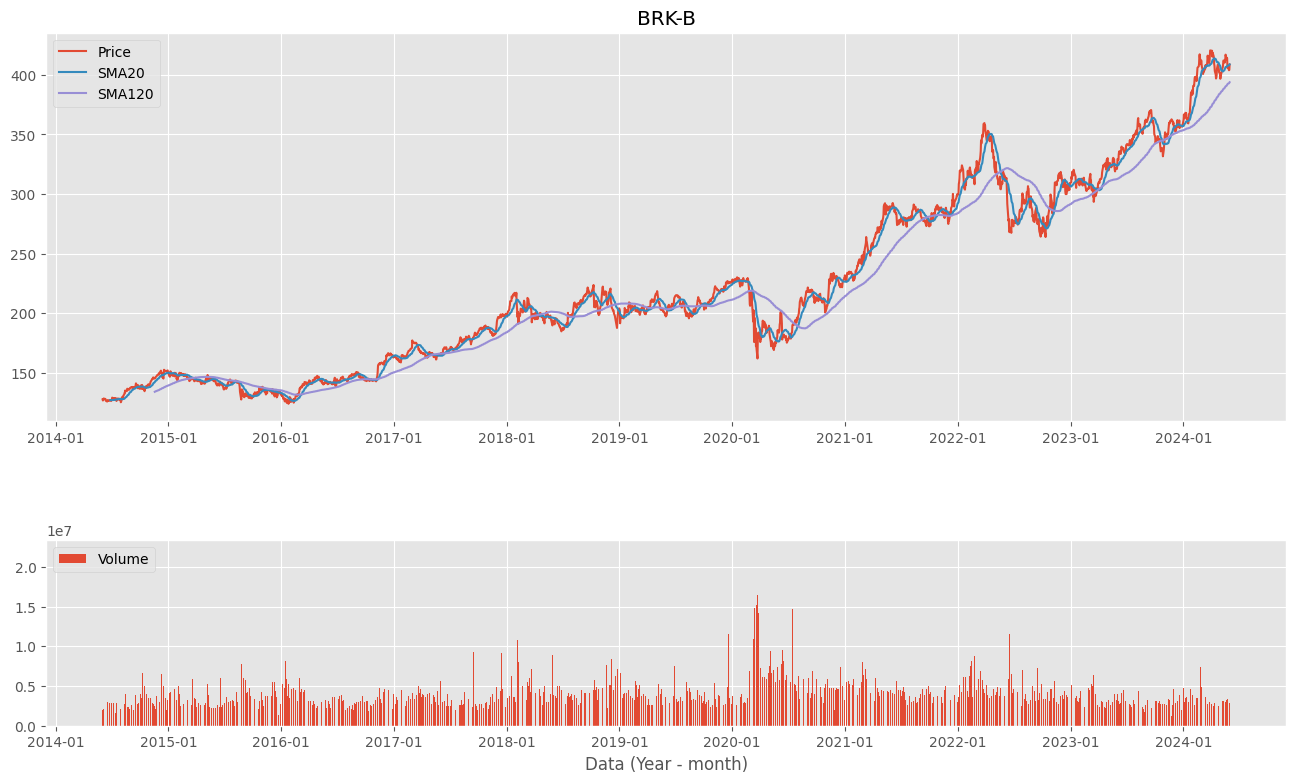

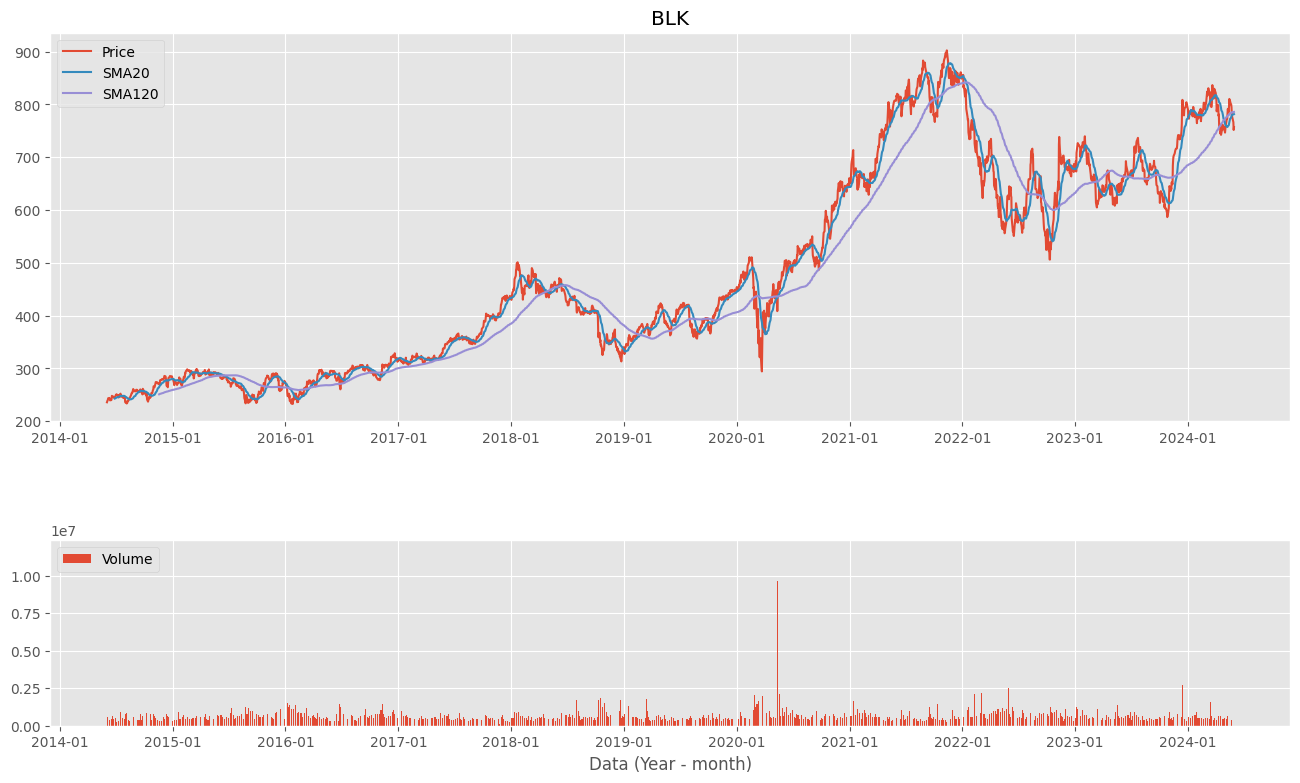

In [35]:
for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_df = stock_dataframes[dataframe_key]

    plt.figure(figsize=(16,9))
    ax1 = plt.subplot2grid((7, 1), (0, 0), rowspan=4, colspan=1, title=ticker)
    ax2 = plt.subplot2grid((7, 1), (5, 0), rowspan=2, colspan=1, sharex=ax1)

    ax1.plot(stock_df['Adj Close'], label='Price')
    ax1.plot(stock_df['SMA20'], label='SMA20')
    ax1.plot(stock_df['SMA120'], label='SMA120')

    ax2.bar(stock_df.index, stock_df['Volume'], label='Volume')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    ax2.set_xlabel('Data (Year - month)')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')

    plt.show()

### Implemento la strategia e rendimenti

In [36]:
sma_data = {}

for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_df = stock_dataframes[dataframe_key]

    stock_df['Price_Yesterday'] = stock_df['Adj Close'].shift(1)
    stock_df['Change'] = stock_df['Adj Close'] / stock_df['Price_Yesterday']
    stock_df['Invested_SMA'] = stock_df.apply(
        lambda row: 1 if row['SMA20'] > row['SMA120'] else 0, axis=1
    )

    sma_key = f"sma_{ticker}"
    sma_data[sma_key] = stock_df[stock_df['Invested_SMA'] == 1]

### Calcolo il prodotto cumulativo

In [37]:
for ticker in selected_stocks:
    sma_key = f"sma_{ticker}"
    sma_data[sma_key] = sma_data[sma_key].copy()
    sma_data[sma_key]['Return'] = np.cumprod(sma_data[sma_key]['Change'].values)

### Calcolo ritorno medio, volatilita' annualizzata e Sharpe ratio

In [38]:
for ticker in selected_stocks:
    sma_key = f"sma_{ticker}"
    sma_data[sma_key] = sma_data[sma_key].copy()
    sma_data[sma_key].loc[:, 'rtn'] = sma_data["sma_" + ticker]['Return'].pct_change()
    sma_data[sma_key].loc[:, 'annual_volatility'] = sma_data[sma_key].loc[:, 'rtn'].std()*np.sqrt(252)
    sma_data[sma_key].loc[:, 'sharpe_ratio'] = sma_data[sma_key].loc[:, 'rtn'].mean()*252 / (sma_data["sma_" + ticker]['rtn'].std()*np.sqrt(252))

# Mostro un ticker di esempio
sma_data["sma_AVGO"]

Adj Close   Volume        SMA20       SMA120  Price_Yesterday  \
Date                                                                          
2014-11-18    70.057014  2002500    65.526793    59.796918        67.842102   
2014-11-19    68.401573  1876300    65.848299    59.912919        70.057014   
2014-11-20    68.922737  1512100    66.175937    60.034466        68.401573   
2014-11-21    69.137306  1746100    66.496293    60.156788        68.922737   
2014-11-24    69.850075  1187600    66.863018    60.283402        69.137306   
...                 ...      ...          ...          ...              ...   
2024-05-23  1393.290039  3103900  1343.982507  1233.163567      1392.239990   
2024-05-24  1407.839966  1672100  1347.171008  1237.213755      1393.290039   
2024-05-28  1412.449951  2291900  1350.862506  1241.352167      1407.839966   
2024-05-29  1390.670044  2686100  1355.382507  1245.398701      1412.449951   
2024-05-30  1364.079956  2172800  1361.443506  1249.301956      1390.670044   

              Change  Invested_SMA    Return       rtn  annual_volatility  \
Date                                                                        
2014-11-18  1.032648             1  1.032648       NaN           0.313716   
2014-11-19  0.976370             1  1.008247 -0.023630           0.313716   
2014-11-20  1.007619             1  1.015929  0.007619           0.313716   
2014-11-21  1.003113             1  1.019091  0.003113           0.313716   
2014-11-24  1.010309             1  1.029598  0.010309           0.313716   
...              ...           ...       ...       ...                ...   
2024-05-23  1.000754             1  9.772088  0.000754           0.313716   
2024-05-24  1.010443             1  9.874137  0.010443           0.313716   
2024-05-28  1.003275             1  9.906470  0.003275           0.313716   
2024-05-29  0.984580             1  9.753712 -0.015420           0.313716   
2024-05-30  0.980880             1  9.567218 -0.019120           0.313716   

            sharpe_ratio  
Date                      
2014-11-18      1.123267  
2014-11-19      1.123267  
2014-11-20      1.123267  
2014-11-21      1.123267  
2014-11-24      1.123267  
...                  ...  
2024-05-23      1.123267  
2024-05-24      1.123267  
2024-05-28      1.123267  
2024-05-29      1.123267  
2024-05-30      1.123267  

[1851 rows x 11 columns]

### Calcolo il rendimento con strategia "Buy and Hold"

In [39]:
for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_data = stock_dataframes[dataframe_key]
    stock_data['Buy_and_hold'] = np.cumprod(stock_data['Change'])

### Confronto i rendimenti

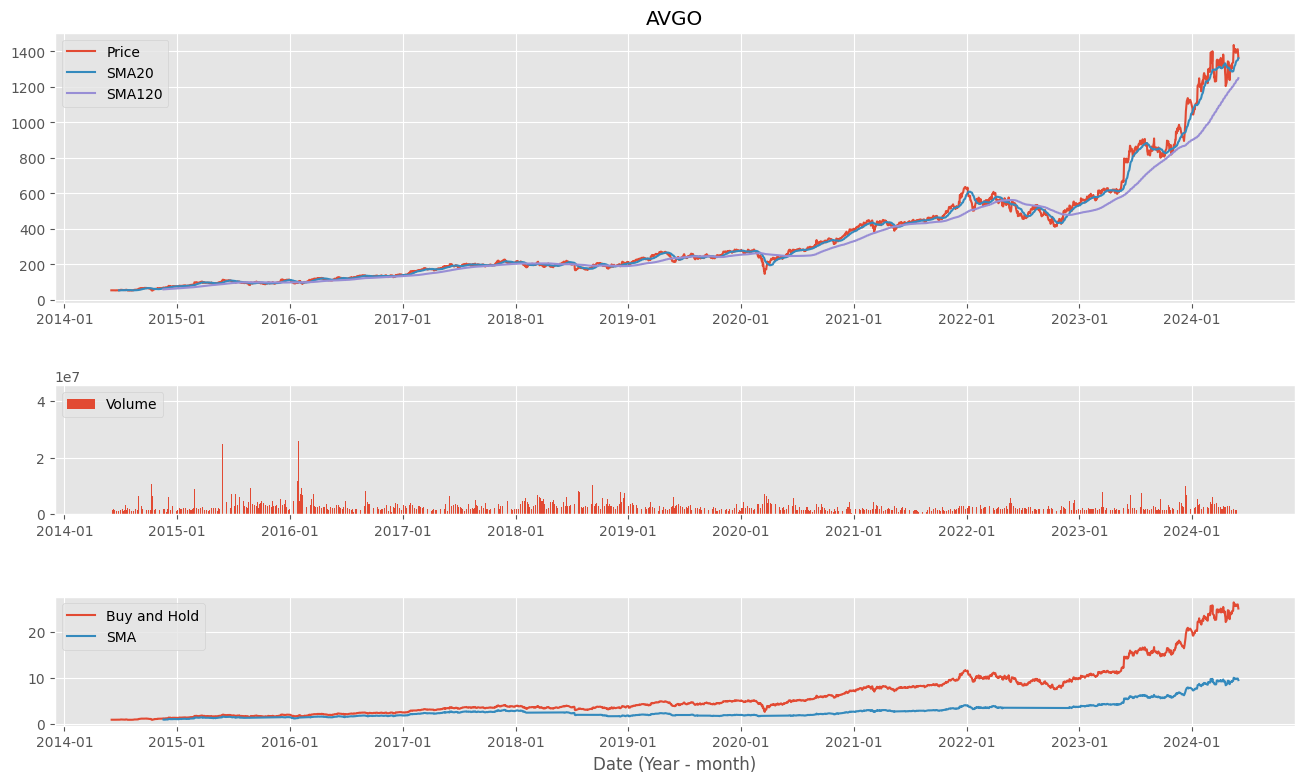

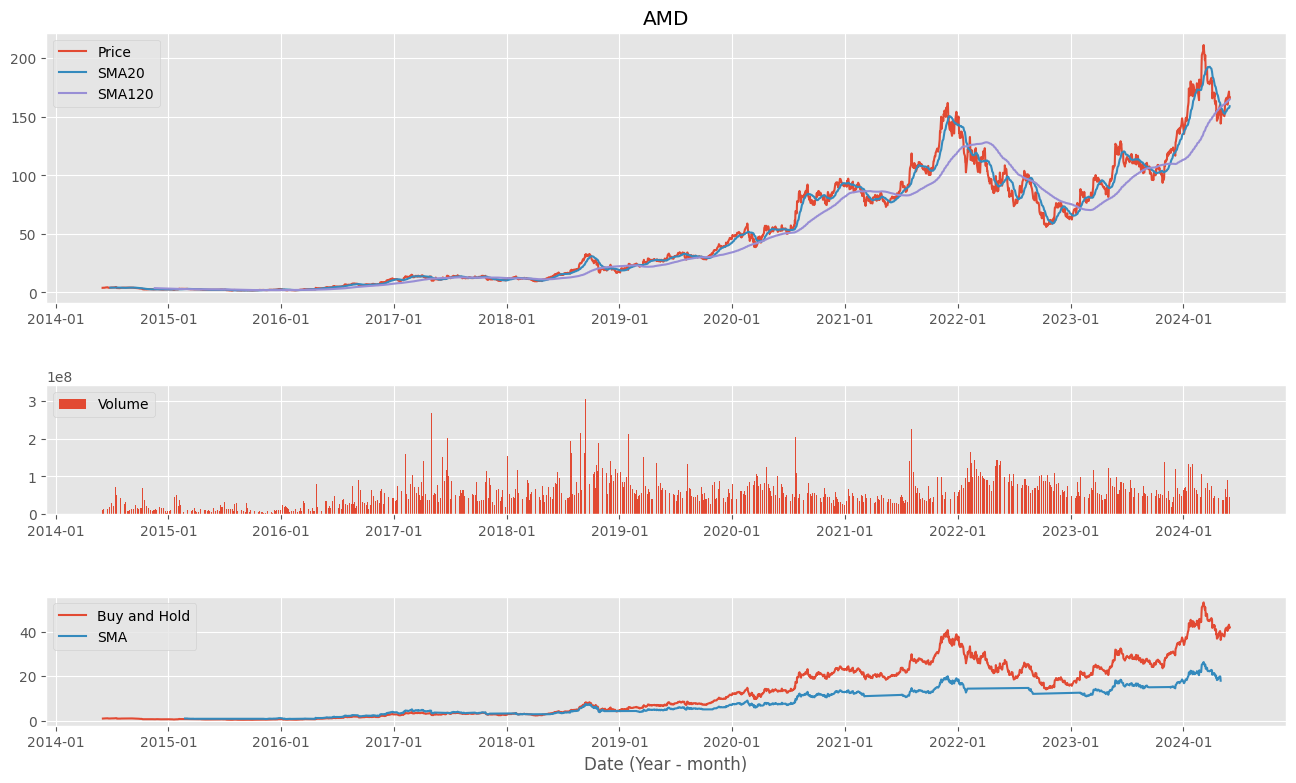

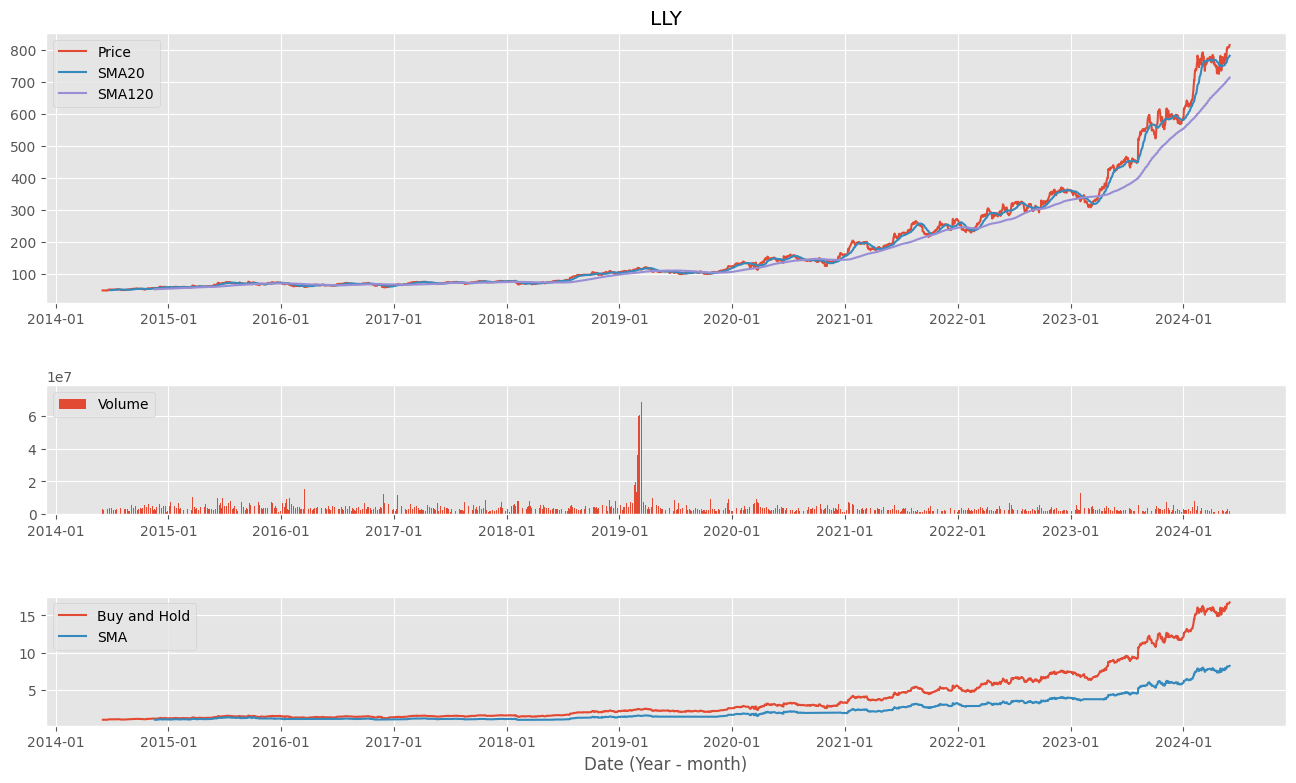

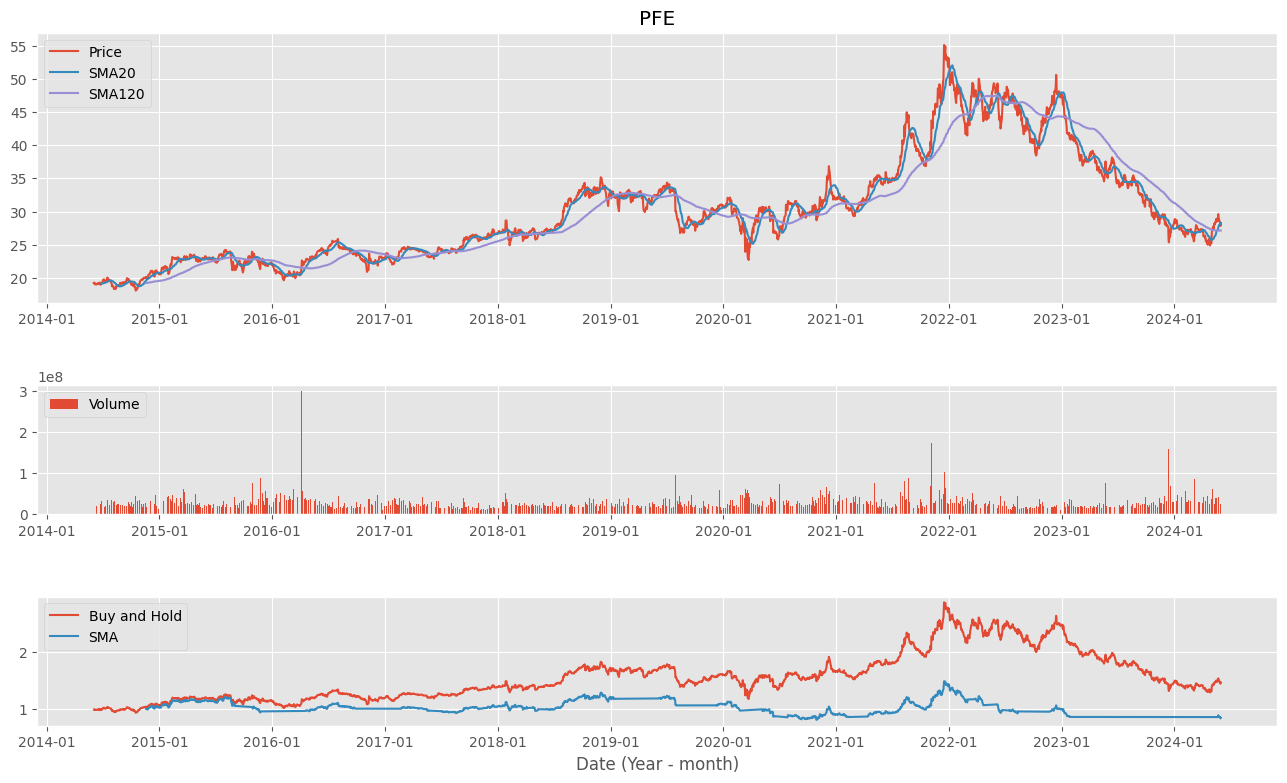

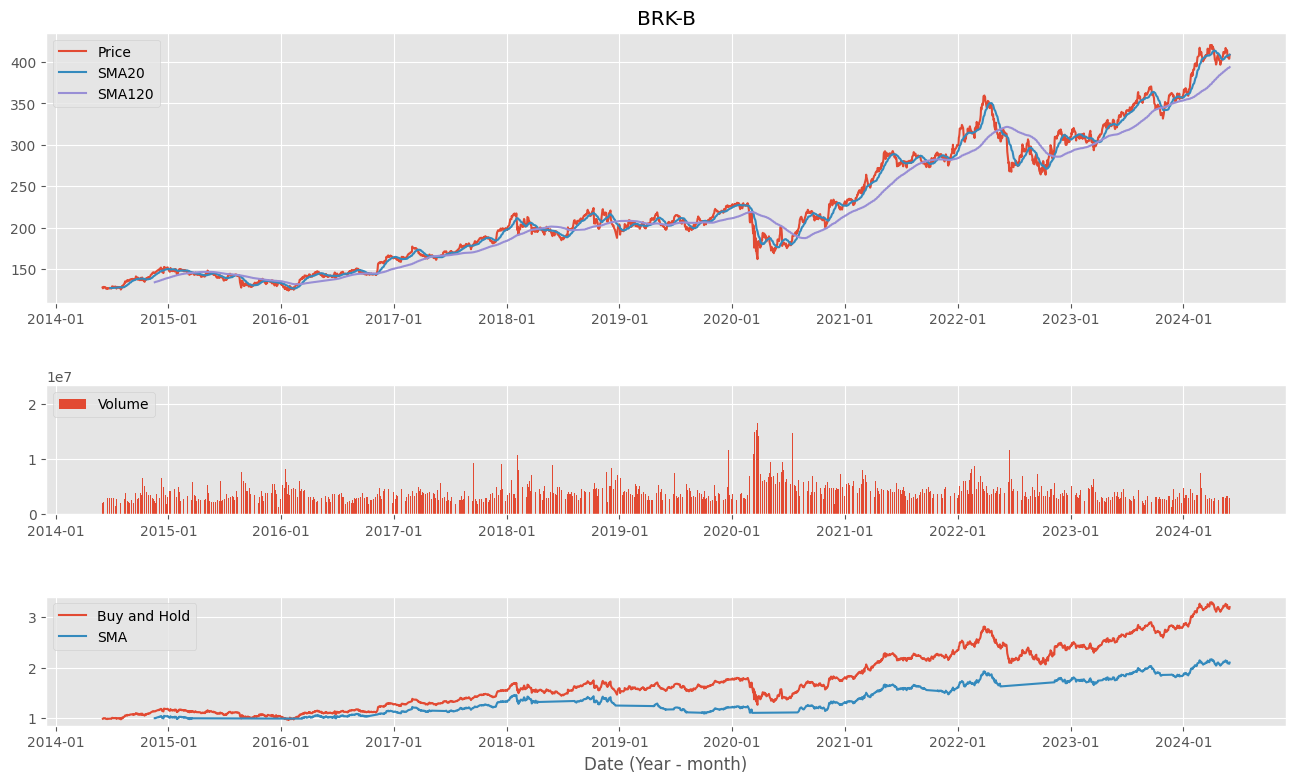

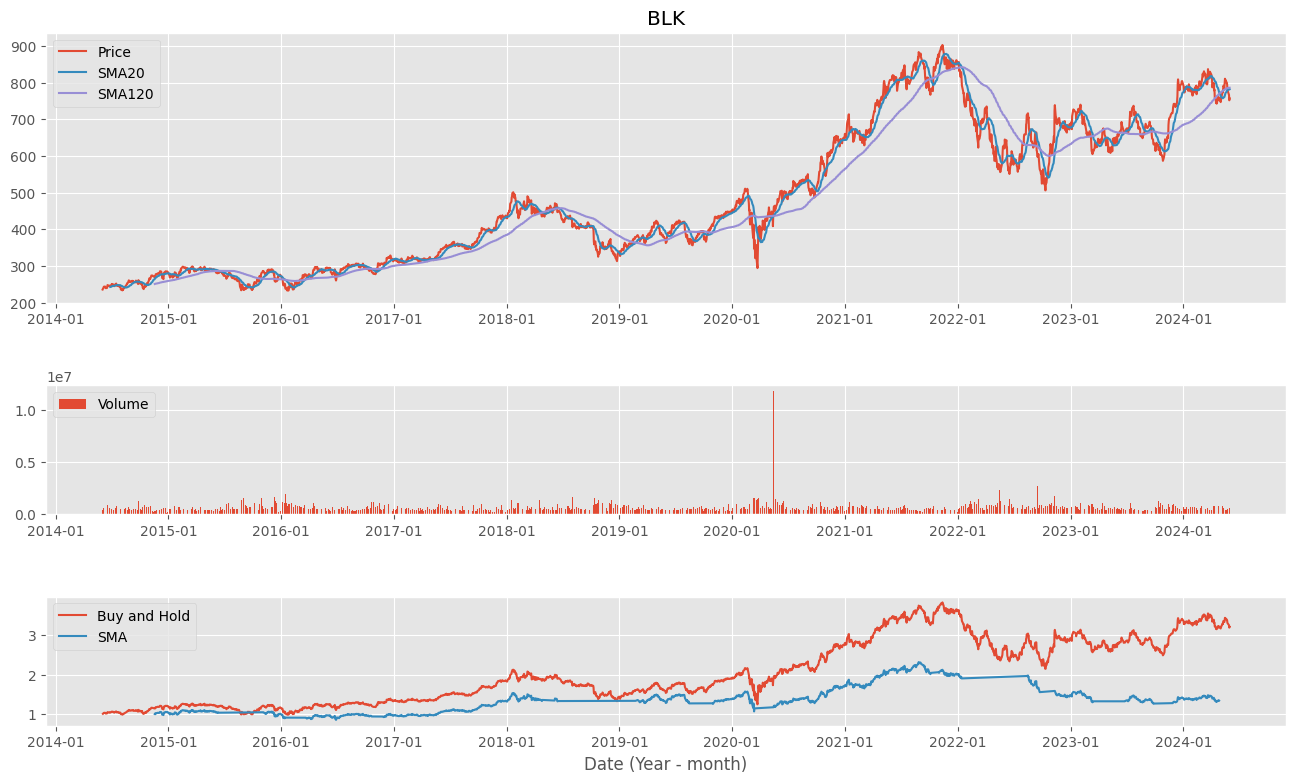

In [40]:
for ticker in selected_stocks:
    stock_data = stock_dataframes[f"df_{ticker}"]
    stock_sma_data = sma_data[f"sma_{ticker}"]


    plt.figure(figsize=(16,9))

    ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1, title=ticker)
    ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=2, colspan=1, sharex=ax1)
    ax3 = plt.subplot2grid((10, 1), (8, 0), rowspan=2, colspan=1, sharex=ax1)

    ax1.plot(stock_data['Adj Close'], label='Price')
    ax1.plot(stock_data['SMA20'], label='SMA20')
    ax1.plot(stock_data['SMA120'], label='SMA120')

    ax2.bar(stock_data.index, stock_data['Volume'], label='Volume')

    ax3.plot(stock_data['Buy_and_hold'], label='Buy and Hold')
    ax3.plot(stock_sma_data['Return'], label='SMA')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax3.set_xlabel('Date (Year - month)')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')
    ax3.legend(loc='upper left')
    plt.show()

### Download dei dataframe con il benchmark di mercato e benchmark risk-free

In [41]:
MARKET_BENCHMARK = '^GSPC'
RISK_FREE_RATE = '^IRX'

capm_data = {}

for ticker in selected_stocks:
    dataframe_key = f"capm_{ticker}"
    capm_data[dataframe_key] = yf.download([ticker, MARKET_BENCHMARK, RISK_FREE_RATE], start=START_DATE, end=END_DATE)

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed


### Calcolo di beta rispetto al benchmark di mercato

In [42]:
assets_beta = {}

for ticker in selected_stocks:
    beta_key = f'beta_{ticker}'
    
    capm_data_key = f'capm_{ticker}'
    capm_data_df = capm_data[capm_data_key]['Adj Close']
    capm_data_df = capm_data_df.rename(columns={ticker: 'asset', MARKET_BENCHMARK: 'market', RISK_FREE_RATE: 'risk_free'})
    
    capm_data_df = capm_data_df.resample('ME').mean()
    capm_data_df['mrf'] = (1 + capm_data_df['risk_free'] / 100)**(30 / 360) - 1
    capm_data_df['asset_nmr'] = capm_data_df['asset'].pct_change() - capm_data_df['mrf']
    capm_data_df['market_nmr'] = capm_data_df['market'].pct_change() - capm_data_df['mrf']

    capm_data_df.dropna(inplace=True)
    
    regression_df = capm_data_df[['asset_nmr', 'market_nmr']]
    covariance = regression_df.cov().iloc[0, 1]
    market_variance = regression_df['market_nmr'].var()
    assets_beta[beta_key] = covariance / market_variance

    y = regression_df.pop('asset_nmr')
    X = sm.add_constant(regression_df)

    model = sm.OLS(y, X).fit()
    
    print('\n' + ticker + '\n')
    print(model.summary())

for asset,beta in assets_beta.items():
    print(f"{asset}: {beta}")


AVGO

                            OLS Regression Results                            
Dep. Variable:              asset_nmr   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     62.97
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           1.41e-12
Time:                        10:08:41   Log-Likelihood:                 172.79
No. Observations:                 119   AIC:                            -341.6
Df Residuals:                     117   BIC:                            -336.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0192      0.005      3.583  

### Scarico i Data Factors

In [43]:
FF_DATA_URL = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"

urllib.request.urlretrieve(FF_DATA_URL,'fama_french.zip')

with zipfile.ZipFile('fama_french.zip', 'r') as zip_ref:
    zip_ref.extractall()

factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)

#Filtro i dati
SEARCH_STRING = ' Annual Factors: January-December '
matching_indices = factor_df.iloc[:, 0] == SEARCH_STRING
start_of_annual_index = factor_df[matching_indices].index[0]
factor_df = factor_df[factor_df.index < start_of_annual_index]

#Rinomino e formatto le colonne
factor_df.columns = ['data', 'mkt', 'smb', 'hml', 'rf']
factor_df['data'] = pd.to_datetime(factor_df['data'], format='%Y%m').dt.strftime("%Y-%m")

### Scarico i DataFrames per Fama-French

In [44]:
fama_french_data = {}

for ticker in selected_stocks:
    dataframe_key = f"ff_df_{ticker}"
    fama_french_data[dataframe_key] = yf.download(ticker, start=START_DATE, end=END_DATE)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Filtro la tabella con START_DATE e END_DATE

In [45]:
factor_df = factor_df.set_index('data')
factor_df = factor_df[START_DATE:END_DATE]
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)

### Strima del modello a tre fattori

In [46]:
for ticker in selected_stocks:
    dataframe_key = f"ff_df_{ticker}"
    
    stock_returns = fama_french_data[dataframe_key]['Adj Close'].resample('ME').last().pct_change().dropna()
    
    stock_returns.index = stock_returns.index.strftime('%Y-%m')
    stock_returns.name = 'rtn'

    ff_data = factor_df.join(stock_returns)
    
    ff_data['excess_rtn'] = ff_data['rtn'] - ff_data['rf']

    average_risk_free_rate = ff_data['rf'].mean()
    average_market_premium = ff_data['mkt'].mean()

    ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', data=ff_data).fit()
    
    print('\n' + ticker + '\n')
    print(ff_model.summary())


AVGO

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     19.92
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           1.88e-10
Time:                        10:08:44   Log-Likelihood:                 149.73
No. Observations:                 118   AIC:                            -291.5
Df Residuals:                     114   BIC:                            -280.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0197      0.007      2.999  

### Calcolo i rendimenti attesi per ogni asset con CAPM

In [47]:
predicted_returns = {}

for ticker in selected_stocks:
    return_key = f"rtn_{ticker}"

    expected_return = average_risk_free_rate + (assets_beta[f'beta_{ticker}'] * average_market_premium)
    annualized_expected_return = expected_return * 12
    predicted_returns[return_key] = annualized_expected_return
    print(f"{ticker}: {annualized_expected_return}")

AVGO: 0.14871095747641178
AMD: 0.25222311526498586
LLY: 0.0505740005034152
PFE: 0.0865316216165817
BRK-B: 0.10227395832616595
BLK: 0.18240571043638204


### Scarico i prezzi e le impostazioni per il portafoglio

In [48]:
NUMBER_OF_PORTFOLIOS = 10000
TRADING_DAYS_PER_YEAR = 252
PORTFOLIO_START_DATE = '2014-05-31'
PORTFOLIO_END_DATE = '2023-05-31'

portfolio_data = yf.download(selected_stocks, start=PORTFOLIO_START_DATE, end=PORTFOLIO_END_DATE)

[*********************100%%**********************]  6 of 6 completed


In [49]:
returns_df = portfolio_data['Adj Close'].pct_change().dropna()
annualized_avg_returns = returns_df.mean() * TRADING_DAYS_PER_YEAR
annualized_covariance_matrix = returns_df.cov() * TRADING_DAYS_PER_YEAR

### Definisco la funzione per calcolare il rendimento e la varianza di un portafoglio

In [50]:
def calculate_portfolio_return_and_variance(weights, expected_returns, covariance_matrix):
    """
    Calcola il rendimento atteso e la varianza di un portafoglio.

    Parametri:
    weights (np.ndarray): Un array di pesi per ciascun asset nel portafoglio.
                          I pesi dovrebbero sommare a 1.
    expected_returns (np.ndarray): Un array di rendimenti attesi per ciascun asset.
    covariance_matrix (np.ndarray): Una matrice 2D che rappresenta la matrice di covarianza dei rendimenti degli asset.

    Restituisce:
    tuple: Una tupla che contiene:
        - portfolio_return (float): Il rendimento atteso del portafoglio.
        - portfolio_variance (float): La varianza del portafoglio.

    Esempio:
    >>> weights = np.array([0.4, 0.6])
    >>> expected_returns = np.array([0.1, 0.2])
    >>> covariance_matrix = np.array([[0.005, -0.010], [-0.010, 0.040]])
    >>> calculate_portfolio_return_and_variance(weights, expected_returns, covariance_matrix)
    (0.16, 0.0084)

    Note:
    - Assicurarsi che il numero di elementi in 'weights' corrisponda al numero di asset.
    - L'array 'expected_returns' deve avere la stessa lunghezza dell'array 'weights'.
    - La 'covariance_matrix' deve essere una matrice quadrata con dimensioni pari alla lunghezza dell'array 'weights'.

    """
    portfolio_return = np.sum(expected_returns * weights)
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    return portfolio_return, portfolio_variance

### Definisco la funzione per generare portafogli casuali

In [51]:
def monte_carlo_simulation(expected_returns, covariance_matrix, num_portfolios):
    """
    Esegue una simulazione Monte Carlo per generare diverse combinazioni di portafogli e calcola il rendimento atteso,
    la varianza e il rapporto Sharpe per ciascun portafoglio.

    Parametri:
    expected_returns (np.ndarray): Un array di rendimenti attesi per ciascun asset.
    covariance_matrix (np.ndarray): Una matrice 2D che rappresenta la matrice di covarianza dei rendimenti degli asset.
    num_portfolios (int): Il numero di portafogli da generare nella simulazione.

    Restituisce:
    tuple: Una tupla che contiene:
        - portfolio_results (np.ndarray): Un array 2D di dimensioni (3, num_portfolios) contenente:
            - rendimento atteso per ciascun portafoglio (portfolio_results[0])
            - varianza per ciascun portafoglio (portfolio_results[1])
            - rapporto Sharpe per ciascun portafoglio (portfolio_results[2])
        - portfolio_random_weights (list): Una lista di array di pesi generati casualmente per ciascun portafoglio.

    Esempio:
    >>> expected_returns = np.array([0.1, 0.2])
    >>> covariance_matrix = np.array([[0.005, -0.010], [-0.010, 0.040]])
    >>> num_portfolios = 10000
    >>> monte_carlo_simulation(expected_returns, covariance_matrix, num_portfolios)
    (array([[...], [...], [...]]), [array([...]), array([...]), ...])

    Note:
    - Assicurarsi che il numero di elementi in 'expected_returns' corrisponda al numero di asset.
    - La 'covariance_matrix' deve essere una matrice quadrata con dimensioni pari alla lunghezza dell'array 'expected_returns'.
    - Il numero di portafogli 'num_portfolios' dovrebbe essere sufficientemente grande per ottenere risultati significativi.

    """
    num_assets = len(expected_returns)
    portfolio_results = np.zeros((3, num_portfolios))
    portfolio_random_weights = []

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        portfolio_random_weights.append(weights)

        portfolio_return, portfolio_variance = calculate_portfolio_return_and_variance(weights, expected_returns, covariance_matrix)

        portfolio_results[0, i] = portfolio_return
        portfolio_results[1, i] = portfolio_variance
        portfolio_results[2, i] = portfolio_return / np.sqrt(portfolio_variance)

    return portfolio_results, portfolio_random_weights

### Genero i risultati e i pesi casuali

In [52]:
results, random_weights = monte_carlo_simulation(annualized_avg_returns, annualized_covariance_matrix, NUMBER_OF_PORTFOLIOS)

### Calcolo i valori migliori

In [53]:
best_index = np.argmax(results[2])
best_weights = random_weights[best_index]

best_return = results[0, best_index]
best_variance = results[1, best_index]

### Calcolo la frontiera efficiente tramite metodo Monte Carlo sui rendimenti passati

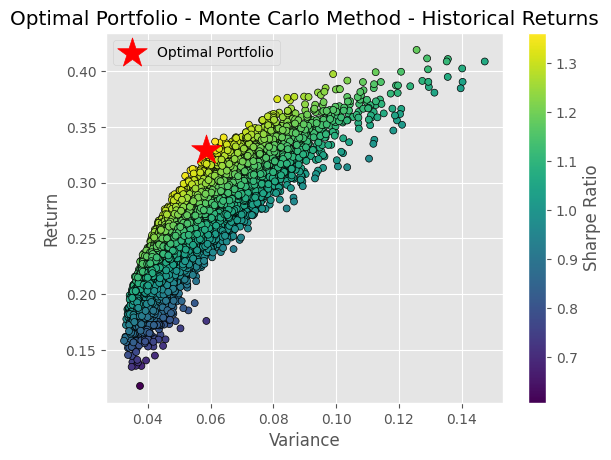

In [54]:
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', edgecolors='black', s=25)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(best_variance, best_return, marker='*', color='r', s=500, label='Optimal Portfolio')

plt.xlabel('Variance')
plt.ylabel('Return')
plt.title('Optimal Portfolio - Monte Carlo Method - Historical Returns')

plt.legend()

plt.show()


### Converto il dizionario in lista e successivamente in array Numpy

In [55]:
expected_returns = np.array(list(predicted_returns.values()))
asset_betas = np.array(list(assets_beta.values()))

### Genero i risultati e i pesi casuali

In [56]:
results, random_weights = monte_carlo_simulation(expected_returns, annualized_covariance_matrix, NUMBER_OF_PORTFOLIOS)

### Calcolo i valori migliori

In [57]:
best_index = np.argmax(results[2])
best_weights = random_weights[best_index]

best_return = results[0, best_index]
best_variance = results[1, best_index]

### Calcolo la frontiera efficiente tramite metodo Monte Carlo sui rendimenti previsti

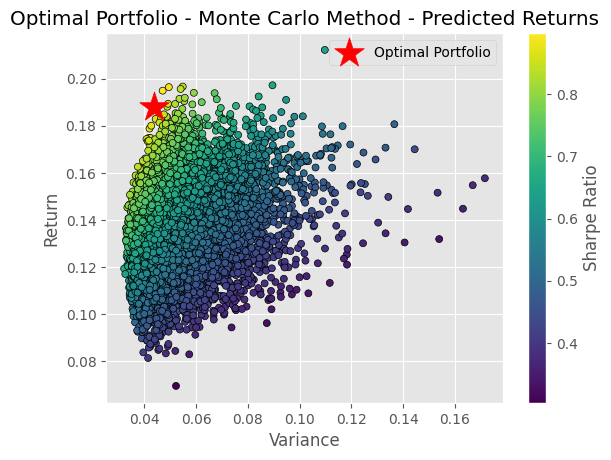

In [58]:
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', edgecolors='black', s=25)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(best_variance, best_return, marker='*', color='r', s=500, label='Optimal Portfolio')

plt.xlabel('Variance')
plt.ylabel('Return')
plt.title('Optimal Portfolio - Monte Carlo Method - Predicted Returns')

plt.legend()

plt.show()

### Calcolo il Beta del portafoglio ottimale

In [59]:
portfolio_beta = np.dot(best_weights, asset_betas)

print(f"Best Portfolio Beta: {portfolio_beta}")

Best Portfolio Beta: 1.5655037174429673


### Calcolo il Beta del portafoglio effettivo


In [60]:
equal_weights = np.ones(len(expected_returns)) / len(expected_returns)
effective_portfolio_beta = np.dot(equal_weights, expected_returns)
print(f"Effective Portfolio Beta: {effective_portfolio_beta}")

Effective Portfolio Beta: 0.13711989393732374
